# Hyperparameter Tuning Tutorial

Machine learning models often have many hyperparameters that need to be tuned to achieve maximal performance (e.g: learning rate, dropout rate, number of layers, layer size, etc) . This motivates the need for hyperparameter tuners that intelligently search the space of hyperparameters for a high performing model. 

To address this, MeTaL supports multiple hyperparameter tuners with an easy to use interface which allows users to streamline the hyperparameter optimization process. This tutorial covers utilizing MeTaL's hyperparameter tuners to tune an EndModel for maximal performance. Currently, two hyperparameter algorithms are supported:

- <b>Random Search</b>
- <b>Hyperband</b>

The tutorial is broken down into the following sections 

1. <b>Set up the Problem and Load the Data</b>
2. <b>Define the Search Space</b>
3. <b>Run Random Search</b>
4. <b>Run Hyperband Search</b>
5. <b>Compare Random Search against Hyperband Search</b>

Let's begin!

## Setup
Before beginning, we first need to make sure that the metal/ directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed snorkel-metal with pip or conda (or that you've added the repo to your path if you're running from source; for example, running source add_to_path.sh from the repository root).

In [48]:
import matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import metal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up the Problem and Load the Data

First let's set up our problem and load our data. For the purposes of this tutorial (and to keep the search process short) we will use the small model introduced in the basic tutorial. 

In [49]:
# Load basic tutorial data
from metal.utils import split_data
import pickle

with open("data/basics_tutorial.pkl", 'rb') as f:
    X, Y, L, D = pickle.load(f)
    
Xs, Ys, Ls, Ds = split_data(X, Y, L, D, splits=[0.8, 0.1, 0.1], stratify_by=Y, seed=123)

Let's define and train our label model like in the basic tutorial.

In [50]:
# Train a the label model
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

label_model.train_model(Ls[0], Y_dev=Ys[1], n_epochs=1000, print_every=250, lr=0.01, l2=1e-1)
scores = label_model.score((Ls[1], Ys[1]), metric=['accuracy','precision', 'recall', 'f1'])

from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1'])
Y_train_ps = label_model.predict_proba(Ls[0])

Computing O...
Estimating \mu...
[E:0]	Train Loss: 6.036
[E:250]	Train Loss: 0.029
[E:500]	Train Loss: 0.029
[E:750]	Train Loss: 0.029
[E:999]	Train Loss: 0.029
Finished Training
Accuracy: 0.879
Precision: 0.771
Recall: 0.724
F1: 0.746
        y=1    y=2   
 l=1    178    53    
 l=2    68     701   
Accuracy: 0.836
Precision: 0.623
Recall: 0.841
F1: 0.716
        y=1    y=2   
 l=1    207    125   
 l=2    39     629   


Now let's define our EndModel and verify that it successfully runs and achieves a decent score. 

In [52]:
# Train an end model
from metal.end_model import EndModel

end_model_basic = EndModel([1000,10,2], 
                     batchnorm=True,
                     dropout=.5,
                     seed=123)

end_model_basic.train_model((Xs[0], Y_train_ps), dev_data=(Xs[1], Ys[1]), l2=0.1, batch_size=256, 
                n_epochs=5, print_every=1, validation_metric='f1')


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)



100%|██████████| 32/32 [00:00<00:00, 142.41it/s, avg_loss=1.96]


Saving model at iteration 0 with best score 0.996
[E:0]	Train Loss: 0.501	Dev score: 0.996


100%|██████████| 32/32 [00:00<00:00, 124.13it/s, avg_loss=1.8]


[E:1]	Train Loss: 0.460	Dev score: 0.949


100%|██████████| 32/32 [00:00<00:00, 160.82it/s, avg_loss=1.77]


[E:2]	Train Loss: 0.454	Dev score: 0.943


100%|██████████| 32/32 [00:00<00:00, 160.60it/s, avg_loss=1.77]


[E:3]	Train Loss: 0.452	Dev score: 0.932


100%|██████████| 32/32 [00:00<00:00, 158.79it/s, avg_loss=1.76]


[E:4]	Train Loss: 0.452	Dev score: 0.959
Restoring best model from iteration 0 with score 0.996
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   


Great. Notice that our F1 is around 0.95. In the sections below we will try to optimize the hyperparameters of this EndModel to achieve an even higher score!

## Define the Search Space

Before starting the hyperparameter tuning process, we need to specify the space of the hyperparameters we're searching. 

For the purposes of this tutorial we search over the following hyperparameters:
- <b>n_epochs</b>: Integer representing the number of epochs to train
- <b>batchnorm</b>: Boolean representing whether to use batch-normalization
- <b>lr</b>: Float representing the learning rate for optimization
- <b>layer_out_dims</b>: The architecture of our neural network

In [53]:
search_space = {
    'n_epochs': [1, 5, 10],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'layer_out_dims' : [[1000,10,2], [1000, 100, 2]],
    'print_every': 5,
    'data_loader_config': [{"batch_size": 256, "num_workers": 1}],
}

Here's a breakdown of what each line in the configuration means:

- `'n_epochs': [1, 5, 10],`: This specifies that the hyperparameter tuner may train the model for either 1, 5 or 10 epochs
- `'batchnorm' : [True, False],`: This specifies that a model instantiated by the tuner may have batchnorm as either True or False
- `dropout': [0, .1, .2, .3, .4, .5]`: Like the above, this specifies that the dropout parameter of an instantiated model may be one of 0, .1, .2, .3, .4, or .5
- `'lr': {'range': [1e-5, 1], 'scale': 'log'}`: This specifies that the learning rate of the training of a model may range from 1e-5 to 1, and that the tuner samples the learning rate on a log scale
- `'layer_out_dims' : [[1000,10,2], [1000, 100, 2]]`: This specifies that upon instantiation of the model, the structure of the fully connected network can either be [1000, 10, 2] or [1000, 100, 2]; in the latter case, this means the network takes a 1000 dimensional input, has a hidden layer with 100 features and an output layer with 2 classes
- `'print_every': 5`: This specifies that the model should print status updates every 5 iterations of training.
- `'data_loader_config': [{"batch_size": 256, "num_workers": 1}],`: This specifies to use a batch of 256 for optimization

Now that our search space is defined, let's start optimizing hyperparameters!

## Run Random Search

While simple, random search has proven to be a powerful and efficient algorithm for tuning hyperparameters (see http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf for why). Let's use the RandomSearch tuner to find a good set of hyperparameters for our EndModel. Note that although we only do hyperparameter optimization for the EndModel, the tuners may also be used to do hyperparameter optimization for LabelModels.

To start, let's import the RandomSearchTuner and instantiate our RandomSearchTuner to optimize an EndModel model.

In [54]:
from metal.tuners.random_tuner import RandomSearchTuner
rs_tuner = RandomSearchTuner(EndModel, seed=123)

Next let's define our training and validation datasets.

In [55]:
train_args = [(Xs[0], Y_train_ps)]
dev_data = (Xs[1], Ys[1])

And just like that we're prepped to launch our random search! Performing the search is just as easy and requires just a single call to the `search` function.

Most of the arguments to the `search` function below are self explanatory, but there are a couple of key arguments to watch out for:
- `max_search` : This specifies the number of configurations to search over. As it is set to 20 below, this means we search over 20 random models and return the best one
- `verbose`: This specifies whether the tuner should be verbose or not and can be used to turn on/off the its logging feature

In [56]:
best_rs_model = rs_tuner.search(search_space, 
                                dev_data,
                                train_args=train_args, 
                                max_search=20, 
                                metric='f1', 
                                verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}


100%|██████████| 32/32 [00:00<00:00, 148.77it/s, avg_loss=4.78]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.223	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 164.65it/s, avg_loss=2.25]


[E:5]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 160.17it/s, avg_loss=2.26]


[E:9]	Train Loss: 0.579	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.827334249624349e-05}


100%|██████████| 32/32 [00:00<00:00, 138.88it/s, avg_loss=2.79]


Saving model at iteration 0 with best score 0.353
[E:0]	Train Loss: 0.714	Dev score: 0.353


100%|██████████| 32/32 [00:00<00:00, 151.05it/s, avg_loss=2.72]


Saving model at iteration 1 with best score 0.578


100%|██████████| 32/32 [00:00<00:00, 136.21it/s, avg_loss=2.66]


Saving model at iteration 2 with best score 0.734


100%|██████████| 32/32 [00:00<00:00, 129.45it/s, avg_loss=2.6]


Saving model at iteration 3 with best score 0.767


100%|██████████| 32/32 [00:00<00:00, 146.73it/s, avg_loss=2.55]


[E:4]	Train Loss: 0.652	Dev score: 0.765
Restoring best model from iteration 3 with score 0.767
Finished Training
Accuracy: 0.767
        y=1    y=2   
 l=1    24     11    
 l=2    222    743   
F1: 0.171
        y=1    y=2   
 l=1    24     11    
 l=2    222    743   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.6366544570068935}


100%|██████████| 32/32 [00:00<00:00, 150.79it/s, avg_loss=43.2]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 11.059	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 149.10it/s, avg_loss=2.31]


[E:5]	Train Loss: 0.590	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 141.43it/s, avg_loss=2.25]


[E:9]	Train Loss: 0.576	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[3] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.31643979593790955}


100%|██████████| 32/32 [00:00<00:00, 149.98it/s, avg_loss=13.9]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 3.548	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 147.70it/s, avg_loss=2.25]


[E:4]	Train Loss: 0.575	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[4] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007292621889903268}


100%|██████████| 32/32 [00:00<00:00, 151.68it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.488	Dev score: 0.994
Restoring best model from iteration 0 with score 0.994
Finished Training
Accuracy: 0.994
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   
F1: 0.988
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[5] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.670624993426239e-05}


100%|██████████| 32/32 [00:00<00:00, 154.96it/s, avg_loss=2.74]


Saving model at iteration 0 with best score 0.530
[E:0]	Train Loss: 0.702	Dev score: 0.530


100%|██████████| 32/32 [00:00<00:00, 154.86it/s, avg_loss=2.68]


Saving model at iteration 1 with best score 0.715


100%|██████████| 32/32 [00:00<00:00, 151.65it/s, avg_loss=2.62]


Saving model at iteration 2 with best score 0.779


100%|██████████| 32/32 [00:00<00:00, 148.33it/s, avg_loss=2.51]


[E:4]	Train Loss: 0.643	Dev score: 0.757
Restoring best model from iteration 2 with score 0.779
Finished Training
Accuracy: 0.779
        y=1    y=2   
 l=1    40     15    
 l=2    206    739   
F1: 0.266
        y=1    y=2   
 l=1    40     15    
 l=2    206    739   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[6] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.5013839780330771}


100%|██████████| 32/32 [00:00<00:00, 150.25it/s, avg_loss=6.48]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.658	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 172.24it/s, avg_loss=2.25]


[E:4]	Train Loss: 0.576	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[7] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008520966193723056}


100%|██████████| 32/32 [00:00<00:00, 154.92it/s, avg_loss=1.89]


Saving model at iteration 0 with best score 0.982
[E:0]	Train Loss: 0.483	Dev score: 0.982
Restoring best model from iteration 0 with score 0.982
Finished Training
Accuracy: 0.982
        y=1    y=2   
 l=1    229     1    
 l=2    17     753   
F1: 0.962
        y=1    y=2   
 l=1    229     1    
 l=2    17     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[8] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003970906941573151}


100%|██████████| 32/32 [00:00<00:00, 154.67it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.491	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 143.06it/s, avg_loss=1.48]


[E:5]	Train Loss: 0.378	Dev score: 0.923


100%|██████████| 32/32 [00:00<00:00, 149.61it/s, avg_loss=1.27]


[E:9]	Train Loss: 0.325	Dev score: 0.915
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[9] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0003777251862528499}


100%|██████████| 32/32 [00:00<00:00, 141.01it/s, avg_loss=2.41]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.617	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[10] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0011538361363759827}


100%|██████████| 32/32 [00:00<00:00, 155.71it/s, avg_loss=2.06]


Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.526	Dev score: 0.990


100%|██████████| 32/32 [00:00<00:00, 157.24it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.991


100%|██████████| 32/32 [00:00<00:00, 156.11it/s, avg_loss=1.62]


[E:5]	Train Loss: 0.416	Dev score: 0.946


100%|██████████| 32/32 [00:00<00:00, 146.30it/s, avg_loss=1.42]


[E:9]	Train Loss: 0.363	Dev score: 0.940
Restoring best model from iteration 1 with score 0.991
Finished Training
Accuracy: 0.991
        y=1    y=2   
 l=1    237     0    
 l=2     9     754   
F1: 0.981
        y=1    y=2   
 l=1    237     0    
 l=2     9     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[11] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.002945528656127802}


100%|██████████| 32/32 [00:00<00:00, 112.51it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.491	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 149.06it/s, avg_loss=1.52]


[E:5]	Train Loss: 0.388	Dev score: 0.944


100%|██████████| 32/32 [00:00<00:00, 146.10it/s, avg_loss=1.27]


[E:9]	Train Loss: 0.325	Dev score: 0.923
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[12] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0026338666324303645}


100%|██████████| 32/32 [00:00<00:00, 156.68it/s, avg_loss=2.16]


Saving model at iteration 0 with best score 0.827
[E:0]	Train Loss: 0.553	Dev score: 0.827
Restoring best model from iteration 0 with score 0.827
Finished Training
Accuracy: 0.827
        y=1    y=2   
 l=1    73      0    
 l=2    173    754   
F1: 0.458
        y=1    y=2   
 l=1    73      0    
 l=2    173    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[13] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.022267690733296888}


100%|██████████| 32/32 [00:00<00:00, 146.28it/s, avg_loss=1.96]


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.501	Dev score: 0.973


100%|██████████| 32/32 [00:00<00:00, 144.04it/s, avg_loss=1.74]


Saving model at iteration 1 with best score 0.976


100%|██████████| 32/32 [00:00<00:00, 147.16it/s, avg_loss=1.53]


[E:4]	Train Loss: 0.391	Dev score: 0.928
Restoring best model from iteration 1 with score 0.976
Finished Training
Accuracy: 0.976
        y=1    y=2   
 l=1    224     2    
 l=2    22     752   
F1: 0.949
        y=1    y=2   
 l=1    224     2    
 l=2    22     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[14] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007561031383400367}


100%|██████████| 32/32 [00:00<00:00, 163.94it/s, avg_loss=1.98]


Saving model at iteration 0 with best score 0.991
[E:0]	Train Loss: 0.506	Dev score: 0.991
Restoring best model from iteration 0 with score 0.991
Finished Training
Accuracy: 0.991
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   
F1: 0.981
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[15] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.3005563286765607e-05}


100%|██████████| 32/32 [00:00<00:00, 164.00it/s, avg_loss=2.62]


Saving model at iteration 0 with best score 0.758
[E:0]	Train Loss: 0.670	Dev score: 0.758


100%|██████████| 32/32 [00:00<00:00, 165.24it/s, avg_loss=2.51]


[E:5]	Train Loss: 0.643	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 165.69it/s, avg_loss=2.42]


[E:9]	Train Loss: 0.620	Dev score: 0.754
Restoring best model from iteration 0 with score 0.758
Finished Training
Accuracy: 0.758
        y=1    y=2   
 l=1     7      3    
 l=2    239    751   
F1: 0.055
        y=1    y=2   
 l=1     7      3    
 l=2    239    751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[16] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 9.272176167778152e-05}


100%|██████████| 32/32 [00:00<00:00, 133.82it/s, avg_loss=2.61]


Saving model at iteration 0 with best score 0.755
[E:0]	Train Loss: 0.667	Dev score: 0.755
Restoring best model from iteration 0 with score 0.755
Finished Training
Accuracy: 0.755
        y=1    y=2   
 l=1     3      2    
 l=2    243    752   
F1: 0.024
        y=1    y=2   
 l=1     3      2    
 l=2    243    752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[17] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.0175385317479292e-05}


100%|██████████| 32/32 [00:00<00:00, 144.73it/s, avg_loss=2.76]


Saving model at iteration 0 with best score 0.385
[E:0]	Train Loss: 0.707	Dev score: 0.385


100%|██████████| 32/32 [00:00<00:00, 140.01it/s, avg_loss=2.72]


Saving model at iteration 1 with best score 0.536


100%|██████████| 32/32 [00:00<00:00, 142.83it/s, avg_loss=2.68]


Saving model at iteration 2 with best score 0.686


100%|██████████| 32/32 [00:00<00:00, 144.60it/s, avg_loss=2.65]


Saving model at iteration 3 with best score 0.744


100%|██████████| 32/32 [00:00<00:00, 141.74it/s, avg_loss=2.61]


Saving model at iteration 4 with best score 0.769


100%|██████████| 32/32 [00:00<00:00, 131.00it/s, avg_loss=2.57]


Saving model at iteration 5 with best score 0.772
[E:5]	Train Loss: 0.659	Dev score: 0.772


100%|██████████| 32/32 [00:00<00:00, 143.54it/s, avg_loss=2.43]


[E:9]	Train Loss: 0.623	Dev score: 0.758
Restoring best model from iteration 5 with score 0.772
Finished Training
Accuracy: 0.772
        y=1    y=2   
 l=1    25      7    
 l=2    221    747   
F1: 0.180
        y=1    y=2   
 l=1    25      7    
 l=2    221    747   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[18] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.07210322639680222}


100%|██████████| 32/32 [00:00<00:00, 148.17it/s, avg_loss=2.88]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.738	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 144.22it/s, avg_loss=2.24]


[E:4]	Train Loss: 0.575	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[19] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003860152812810654}


100%|██████████| 32/32 [00:00<00:00, 163.08it/s, avg_loss=2.05]


Saving model at iteration 0 with best score 0.986
[E:0]	Train Loss: 0.526	Dev score: 0.986


100%|██████████| 32/32 [00:00<00:00, 159.87it/s, avg_loss=1.8]


Saving model at iteration 1 with best score 0.987


100%|██████████| 32/32 [00:00<00:00, 159.27it/s, avg_loss=1.69]


[E:5]	Train Loss: 0.432	Dev score: 0.974


100%|██████████| 32/32 [00:00<00:00, 150.59it/s, avg_loss=1.62]


[E:9]	Train Loss: 0.414	Dev score: 0.930
Restoring best model from iteration 1 with score 0.987
Finished Training
Accuracy: 0.987
        y=1    y=2   
 l=1    234     1    
 l=2    12     753   
F1: 0.973
        y=1    y=2   
 l=1    234     1    
 l=2    12     753   
[SUMMARY]
Best model: [8]
Best config: {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003970906941573151, 'seed': 131}
Best score: 0.9959349593495935


Awesome, our best random search model achieves an F1 of ~.996 which outperforms the model we had previously (F1 ~ .90). Can we do even better than random search by either attaining the same accuracy faster or achieving a higher score? The following section walks through using the <b>Hyperband</b> tuner, which recent research has shown to be more efficient than random search.

## Run Hyperband Search

While random search performs surprisingly well, we can be more efficient if we adaptively allocate more compute resources for configurations that perform well than to those that don't. For example if a configuration seems to yield a really poor model after the first epoch of training, it's unlikely it'll perform well even after more training, so we can early-terminate the training of this configuration to save compute. This is the core idea behind the <b>Hyperband</b> algorithm which recent research has shown to outperform various algorithms including random search. (See https://arxiv.org/abs/1603.06560 if interested!)

Running Hyperband is just as easy as running random search. Let's import the HyperbandTuner and instantiate it. 

Note that there is one extra argument to initialize the HyperbandTuner:
- `hyperband_epochs_budget`: This specifies the number of total epochs of training the tuner can perform in its search for a performant model. This is used to create the Hyperband search schedule.

In [57]:
from metal.tuners.hyperband_tuner import HyperbandTuner
hb_tuner = HyperbandTuner(EndModel, hyperband_epochs_budget=200, seed=123)

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config)which specify how many configs to run andfor how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (9, 2) (3, 8) (1, 26)
Bracket 1: (3, 8) (1, 26)
Bracket 2: (3, 26)
-----------------------------------------


We can launch the Hyperband search process using the same `search` call. Note that since the Hyperband schedule already limits the amount of compute we do, we don't have to set the `max_search` argument.

In [58]:
best_hb_model = hb_tuner.search(search_space, dev_data, train_args=train_args, metric='f1', verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}


100%|██████████| 32/32 [00:00<00:00, 136.62it/s, avg_loss=4.78]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.223	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 148.83it/s, avg_loss=2.25]


[E:1]	Train Loss: 0.575	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.019515100267567337}


100%|██████████| 32/32 [00:00<00:00, 132.63it/s, avg_loss=1.95]


Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.500	Dev score: 0.990


100%|██████████| 32/32 [00:00<00:00, 132.49it/s, avg_loss=1.77]


[E:1]	Train Loss: 0.454	Dev score: 0.981
Restoring best model from iteration 0 with score 0.990
Finished Training
Accuracy: 0.990
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   
F1: 0.979
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 7.089807415516936e-05}


100%|██████████| 32/32 [00:00<00:00, 97.02it/s, avg_loss=2.61]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.667	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 127.31it/s, avg_loss=2.41]


[E:1]	Train Loss: 0.617	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 2, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0004837052086066461}


100%|██████████| 32/32 [00:00<00:00, 146.68it/s, avg_loss=2.22]


Saving model at iteration 0 with best score 0.757
[E:0]	Train Loss: 0.568	Dev score: 0.757


100%|██████████| 32/32 [00:00<00:00, 142.09it/s, avg_loss=1.84]


Saving model at iteration 1 with best score 0.986
[E:1]	Train Loss: 0.471	Dev score: 0.986
Restoring best model from iteration 1 with score 0.986
Finished Training
Accuracy: 0.986
        y=1    y=2   
 l=1    232     0    
 l=2    14     754   
F1: 0.971
        y=1    y=2   
 l=1    232     0    
 l=2    14     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.000903579845523744}


100%|██████████| 32/32 [00:00<00:00, 145.58it/s, avg_loss=2.07]


Saving model at iteration 0 with best score 0.955
[E:0]	Train Loss: 0.530	Dev score: 0.955


100%|██████████| 32/32 [00:00<00:00, 146.91it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.995
[E:1]	Train Loss: 0.456	Dev score: 0.995
Restoring best model from iteration 1 with score 0.995
Finished Training
Accuracy: 0.995
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   
F1: 0.990
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.3251656081342196e-05}


100%|██████████| 32/32 [00:00<00:00, 135.17it/s, avg_loss=2.73]


Saving model at iteration 0 with best score 0.630
[E:0]	Train Loss: 0.698	Dev score: 0.630


100%|██████████| 32/32 [00:00<00:00, 144.57it/s, avg_loss=2.64]


Saving model at iteration 1 with best score 0.778
[E:1]	Train Loss: 0.677	Dev score: 0.778
Restoring best model from iteration 1 with score 0.778
Finished Training
Accuracy: 0.778
        y=1    y=2   
 l=1    45     21    
 l=2    201    733   
F1: 0.288
        y=1    y=2   
 l=1    45     21    
 l=2    201    733   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_6] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0019223627877981123}


100%|██████████| 32/32 [00:00<00:00, 165.41it/s, avg_loss=2.13]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.546	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 161.67it/s, avg_loss=1.82]


Saving model at iteration 1 with best score 0.994
[E:1]	Train Loss: 0.465	Dev score: 0.994
Restoring best model from iteration 1 with score 0.994
Finished Training
Accuracy: 0.994
        y=1    y=2   
 l=1    240     0    
 l=2     6     754   
F1: 0.988
        y=1    y=2   
 l=1    240     0    
 l=2     6     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_7] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007342476624077729}


100%|██████████| 32/32 [00:00<00:00, 144.53it/s, avg_loss=1.89]


Saving model at iteration 0 with best score 0.983
[E:0]	Train Loss: 0.483	Dev score: 0.983


100%|██████████| 32/32 [00:00<00:00, 147.18it/s, avg_loss=1.73]


[E:1]	Train Loss: 0.444	Dev score: 0.977
Restoring best model from iteration 0 with score 0.983
Finished Training
Accuracy: 0.983
        y=1    y=2   
 l=1    230     1    
 l=2    16     753   
F1: 0.964
        y=1    y=2   
 l=1    230     1    
 l=2    16     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_8] Testing {'n_epochs': 2, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00047921510264231735}


100%|██████████| 32/32 [00:00<00:00, 126.40it/s, avg_loss=2.21]


Saving model at iteration 0 with best score 0.756
[E:0]	Train Loss: 0.564	Dev score: 0.756


100%|██████████| 32/32 [00:00<00:00, 145.28it/s, avg_loss=1.84]


Saving model at iteration 1 with best score 0.983
[E:1]	Train Loss: 0.471	Dev score: 0.983
Restoring best model from iteration 1 with score 0.983
Finished Training
Accuracy: 0.983
        y=1    y=2   
 l=1    229     0    
 l=2    17     754   
F1: 0.964
        y=1    y=2   
 l=1    229     0    
 l=2    17     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.000903579845523744}


100%|██████████| 32/32 [00:00<00:00, 146.25it/s, avg_loss=2.07]


Saving model at iteration 0 with best score 0.955
[E:0]	Train Loss: 0.530	Dev score: 0.955


100%|██████████| 32/32 [00:00<00:00, 140.14it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.995


100%|██████████| 32/32 [00:00<00:00, 147.24it/s, avg_loss=1.65]


[E:5]	Train Loss: 0.423	Dev score: 0.970


100%|██████████| 32/32 [00:00<00:00, 139.91it/s, avg_loss=1.58]


[E:7]	Train Loss: 0.405	Dev score: 0.953
Restoring best model from iteration 1 with score 0.995
Finished Training
Accuracy: 0.995
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   
F1: 0.990
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0019223627877981123}


100%|██████████| 32/32 [00:00<00:00, 160.77it/s, avg_loss=2.13]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.546	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 159.30it/s, avg_loss=1.82]


Saving model at iteration 1 with best score 0.994


100%|██████████| 32/32 [00:00<00:00, 162.47it/s, avg_loss=1.72]


[E:5]	Train Loss: 0.440	Dev score: 0.977


100%|██████████| 32/32 [00:00<00:00, 161.02it/s, avg_loss=1.69]


[E:7]	Train Loss: 0.433	Dev score: 0.975
Restoring best model from iteration 1 with score 0.994
Finished Training
Accuracy: 0.994
        y=1    y=2   
 l=1    240     0    
 l=2     6     754   
F1: 0.988
        y=1    y=2   
 l=1    240     0    
 l=2     6     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_2] Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.019515100267567337}


100%|██████████| 32/32 [00:00<00:00, 146.11it/s, avg_loss=1.95]


Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.500	Dev score: 0.990


100%|██████████| 32/32 [00:00<00:00, 144.17it/s, avg_loss=1.48]


[E:5]	Train Loss: 0.380	Dev score: 0.904


100%|██████████| 32/32 [00:00<00:00, 145.71it/s, avg_loss=1.42]


[E:7]	Train Loss: 0.365	Dev score: 0.906
Restoring best model from iteration 0 with score 0.990
Finished Training
Accuracy: 0.990
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   
F1: 0.979
        y=1    y=2   
 l=1    237     1    
 l=2     9     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2_0] Testing {'n_epochs': 26, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.000903579845523744}


100%|██████████| 32/32 [00:00<00:00, 113.35it/s, avg_loss=2.07]


Saving model at iteration 0 with best score 0.955
[E:0]	Train Loss: 0.530	Dev score: 0.955


100%|██████████| 32/32 [00:00<00:00, 138.84it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.995


100%|██████████| 32/32 [00:00<00:00, 143.83it/s, avg_loss=1.65]


[E:5]	Train Loss: 0.423	Dev score: 0.970


100%|██████████| 32/32 [00:00<00:00, 143.02it/s, avg_loss=1.46]


[E:10]	Train Loss: 0.373	Dev score: 0.943


100%|██████████| 32/32 [00:00<00:00, 142.56it/s, avg_loss=1.28]


[E:15]	Train Loss: 0.327	Dev score: 0.940


100%|██████████| 32/32 [00:00<00:00, 105.90it/s, avg_loss=1.2]


[E:20]	Train Loss: 0.308	Dev score: 0.935


100%|██████████| 32/32 [00:00<00:00, 131.33it/s, avg_loss=1.18]


[E:25]	Train Loss: 0.302	Dev score: 0.936
Restoring best model from iteration 1 with score 0.995
Finished Training
Accuracy: 0.995
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   
F1: 0.990
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 8, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0012901865145961697}


100%|██████████| 32/32 [00:00<00:00, 116.00it/s, avg_loss=2.34]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.599	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 144.31it/s, avg_loss=1.9]


Saving model at iteration 1 with best score 0.922


100%|██████████| 32/32 [00:00<00:00, 134.12it/s, avg_loss=1.82]


Saving model at iteration 2 with best score 0.970


100%|██████████| 32/32 [00:00<00:00, 161.21it/s, avg_loss=1.8]


Saving model at iteration 3 with best score 0.975


100%|██████████| 32/32 [00:00<00:00, 162.79it/s, avg_loss=1.78]


Saving model at iteration 5 with best score 0.983
[E:5]	Train Loss: 0.456	Dev score: 0.983


100%|██████████| 32/32 [00:00<00:00, 133.99it/s, avg_loss=1.76]


[E:7]	Train Loss: 0.451	Dev score: 0.979
Restoring best model from iteration 5 with score 0.983
Finished Training
Accuracy: 0.983
        y=1    y=2   
 l=1    230     1    
 l=2    16     753   
F1: 0.964
        y=1    y=2   
 l=1    230     1    
 l=2    16     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0014465786197803271}


100%|██████████| 32/32 [00:00<00:00, 139.37it/s, avg_loss=1.96]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.503	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 110.43it/s, avg_loss=1.59]


[E:5]	Train Loss: 0.407	Dev score: 0.950


100%|██████████| 32/32 [00:00<00:00, 141.51it/s, avg_loss=1.47]


[E:7]	Train Loss: 0.377	Dev score: 0.937
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 8, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007585836552838511}


100%|██████████| 32/32 [00:00<00:00, 142.74it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.996
[E:0]	Train Loss: 0.491	Dev score: 0.996


100%|██████████| 32/32 [00:00<00:00, 134.58it/s, avg_loss=1.41]


[E:5]	Train Loss: 0.361	Dev score: 0.906


100%|██████████| 32/32 [00:00<00:00, 143.94it/s, avg_loss=1.3]


[E:7]	Train Loss: 0.334	Dev score: 0.910
Restoring best model from iteration 0 with score 0.996
Finished Training
Accuracy: 0.996
        y=1    y=2   
 l=1    244     2    
 l=2     2     752   
F1: 0.992
        y=1    y=2   
 l=1    244     2    
 l=2     2     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 26, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0014465786197803271}


100%|██████████| 32/32 [00:00<00:00, 139.22it/s, avg_loss=1.96]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.503	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 139.91it/s, avg_loss=1.59]


[E:5]	Train Loss: 0.407	Dev score: 0.950


100%|██████████| 32/32 [00:00<00:00, 138.48it/s, avg_loss=1.3]


[E:10]	Train Loss: 0.334	Dev score: 0.927


100%|██████████| 32/32 [00:00<00:00, 143.33it/s, avg_loss=1.2]


[E:15]	Train Loss: 0.308	Dev score: 0.922


100%|██████████| 32/32 [00:00<00:00, 143.84it/s, avg_loss=1.19]


[E:20]	Train Loss: 0.306	Dev score: 0.930


100%|██████████| 32/32 [00:00<00:00, 94.29it/s, avg_loss=1.18]


[E:25]	Train Loss: 0.302	Dev score: 0.911
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 26, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 4.6632716175331675e-05}


100%|██████████| 32/32 [00:00<00:00, 125.51it/s, avg_loss=2.7]


Saving model at iteration 0 with best score 0.763
[E:0]	Train Loss: 0.690	Dev score: 0.763


100%|██████████| 32/32 [00:00<00:00, 137.92it/s, avg_loss=2.07]


[E:5]	Train Loss: 0.531	Dev score: 0.757


100%|██████████| 32/32 [00:00<00:00, 143.56it/s, avg_loss=1.97]


Saving model at iteration 7 with best score 0.774


100%|██████████| 32/32 [00:00<00:00, 123.26it/s, avg_loss=1.94]


Saving model at iteration 8 with best score 0.797


100%|██████████| 32/32 [00:00<00:00, 143.55it/s, avg_loss=1.9]


Saving model at iteration 9 with best score 0.833


100%|██████████| 32/32 [00:00<00:00, 137.79it/s, avg_loss=1.87]


Saving model at iteration 10 with best score 0.866
[E:10]	Train Loss: 0.479	Dev score: 0.866


100%|██████████| 32/32 [00:00<00:00, 143.52it/s, avg_loss=1.85]


Saving model at iteration 11 with best score 0.901


100%|██████████| 32/32 [00:00<00:00, 129.29it/s, avg_loss=1.83]


Saving model at iteration 12 with best score 0.920


100%|██████████| 32/32 [00:00<00:00, 138.98it/s, avg_loss=1.81]


Saving model at iteration 13 with best score 0.940


100%|██████████| 32/32 [00:00<00:00, 143.59it/s, avg_loss=1.8]


Saving model at iteration 14 with best score 0.956


100%|██████████| 32/32 [00:00<00:00, 106.88it/s, avg_loss=1.79]


Saving model at iteration 15 with best score 0.966
[E:15]	Train Loss: 0.458	Dev score: 0.966


100%|██████████| 32/32 [00:00<00:00, 142.30it/s, avg_loss=1.78]


Saving model at iteration 16 with best score 0.971


100%|██████████| 32/32 [00:00<00:00, 138.71it/s, avg_loss=1.78]


Saving model at iteration 17 with best score 0.973


100%|██████████| 32/32 [00:00<00:00, 138.83it/s, avg_loss=1.77]


Saving model at iteration 18 with best score 0.977


100%|██████████| 32/32 [00:00<00:00, 141.62it/s, avg_loss=1.77]


Saving model at iteration 19 with best score 0.978


100%|██████████| 32/32 [00:00<00:00, 144.70it/s, avg_loss=1.76]


[E:20]	Train Loss: 0.451	Dev score: 0.978


100%|██████████| 32/32 [00:00<00:00, 136.23it/s, avg_loss=1.75]


[E:25]	Train Loss: 0.447	Dev score: 0.978
Restoring best model from iteration 19 with score 0.978
Finished Training
Accuracy: 0.978
        y=1    y=2   
 l=1    224     0    
 l=2    22     754   
F1: 0.953
        y=1    y=2   
 l=1    224     0    
 l=2    22     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.05250533013212389}


100%|██████████| 32/32 [00:00<00:00, 142.82it/s, avg_loss=2.63]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.674	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 139.47it/s, avg_loss=2.07]


Saving model at iteration 1 with best score 0.960


100%|██████████| 32/32 [00:00<00:00, 105.53it/s, avg_loss=1.8]


Saving model at iteration 2 with best score 0.974


100%|██████████| 32/32 [00:00<00:00, 143.17it/s, avg_loss=1.77]


Saving model at iteration 3 with best score 0.979


100%|██████████| 32/32 [00:00<00:00, 144.72it/s, avg_loss=1.75]


[E:5]	Train Loss: 0.447	Dev score: 0.957


100%|██████████| 32/32 [00:00<00:00, 144.55it/s, avg_loss=1.74]


[E:10]	Train Loss: 0.445	Dev score: 0.969


100%|██████████| 32/32 [00:00<00:00, 122.79it/s, avg_loss=1.71]


[E:15]	Train Loss: 0.438	Dev score: 0.965


100%|██████████| 32/32 [00:00<00:00, 144.17it/s, avg_loss=1.71]


[E:20]	Train Loss: 0.438	Dev score: 0.966


100%|██████████| 32/32 [00:00<00:00, 57.91it/s, avg_loss=1.7]


[E:25]	Train Loss: 0.435	Dev score: 0.965
Restoring best model from iteration 3 with score 0.979
Finished Training
Accuracy: 0.979
        y=1    y=2   
 l=1    238    13    
 l=2     8     741   
F1: 0.958
        y=1    y=2   
 l=1    238    13    
 l=2     8     741   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 26, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.14487792589370782}


100%|██████████| 32/32 [00:00<00:00, 112.25it/s, avg_loss=4.65]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.191	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 139.91it/s, avg_loss=2.27]


Saving model at iteration 1 with best score 0.756


100%|██████████| 32/32 [00:00<00:00, 140.88it/s, avg_loss=2.3]


Saving model at iteration 3 with best score 0.773


100%|██████████| 32/32 [00:00<00:00, 142.94it/s, avg_loss=2.27]


Saving model at iteration 4 with best score 0.878


100%|██████████| 32/32 [00:00<00:00, 129.63it/s, avg_loss=2.29]


[E:5]	Train Loss: 0.586	Dev score: 0.756


100%|██████████| 32/32 [00:00<00:00, 125.79it/s, avg_loss=2.15]


Saving model at iteration 7 with best score 0.896


100%|██████████| 32/32 [00:00<00:00, 144.16it/s, avg_loss=1.9]


Saving model at iteration 10 with best score 0.920
[E:10]	Train Loss: 0.488	Dev score: 0.920


100%|██████████| 32/32 [00:00<00:00, 139.29it/s, avg_loss=1.75]


Saving model at iteration 12 with best score 0.923


100%|██████████| 32/32 [00:00<00:00, 140.19it/s, avg_loss=1.71]


[E:15]	Train Loss: 0.438	Dev score: 0.894


100%|██████████| 32/32 [00:00<00:00, 115.56it/s, avg_loss=1.71]


[E:20]	Train Loss: 0.437	Dev score: 0.900


100%|██████████| 32/32 [00:00<00:00, 52.40it/s, avg_loss=1.68]


[E:25]	Train Loss: 0.430	Dev score: 0.906
Restoring best model from iteration 12 with score 0.923
Finished Training
Accuracy: 0.923
        y=1    y=2   
 l=1    177     8    
 l=2    69     746   
F1: 0.821
        y=1    y=2   
 l=1    177     8    
 l=2    69     746   
[SUMMARY]
Best model: [0_1]
Best config: {'n_epochs': 26, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0014465786197803271, 'seed': 137}
Best score: 0.9959349593495935


Awesome, we achieved an F1 ~.994, which beat our initial score of F1 ~.90 and essentially matches the score achieved by random search (F1 ~.996). The next section will compare the performances of random search and Hyperband using the logged data -- and investigate when to use which algorithm.

## Compare Random Search against Hyperband Search

During `search`, MeTaL hyperparameter tuners track useful statistics. Currently these include
* Time elapsed
* Best score
* Best configuration

We will analyze these statistics to compare random search against Hyperband. 

First, let's extract the statistics captured by our tuners.

In [39]:
hb_stats = hb_tuner.run_stats
rs_stats = rs_tuner.run_stats

Let's take a look at a few of the collected datapoints

In [40]:
hb_stats[:3]

[{'idx': '0_0',
  'time_elapsed': 0.6589169502258301,
  'search_params': {'n_epochs': 2,
   'batchnorm': False,
   'dropout': 0,
   'layer_out_dims': [1000, 10, 2],
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.3700237151852522},
  'score': 0,
  'best_score': 0},
 {'idx': '0_1',
  'time_elapsed': 1.3525810241699219,
  'search_params': {'n_epochs': 2,
   'batchnorm': False,
   'dropout': 0.1,
   'layer_out_dims': [1000, 100, 2],
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 0.019515100267567337},
  'score': 0.9793388429752067,
  'best_score': 0.9793388429752067},
 {'idx': '0_2',
  'time_elapsed': 2.0790369510650635,
  'search_params': {'n_epochs': 2,
   'batchnorm': False,
   'dropout': 0.4,
   'layer_out_dims': [1000, 100, 2],
   'data_loader_config': {'batch_size': 256, 'num_workers': 1},
   'lr': 7.089807415516936e-05},
  'score': 0,
  'best_score': 0.9793388429752067}]

`run_stats` contains a list of datapoints, where each datapoint (captured by a dictionary) specifies the current elapsed timestamp, the best score achieved for that timestamp and the best hyperparameter configuration for the score.

Now that we have our data and understand its format, let's compare the performances of random search and hyperband by plotting the best scores they achieve across time!

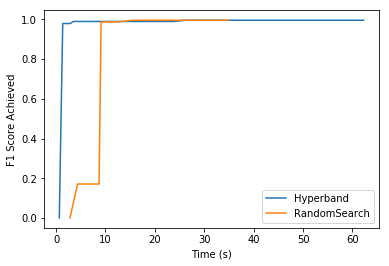

In [41]:
import matplotlib.pyplot as plt

def plot_score_vs_time(rs_data, hb_data):
    plt.cla()
    
    xs_hyperband = [x["time_elapsed"] for x in hb_data]
    ys_hyperband = [x["best_score"] for x in hb_data]
    xs_rs = [x["time_elapsed"] for x in rs_data]
    ys_rs = [x["best_score"] for x in rs_data]
    
    plt.plot(xs_hyperband, ys_hyperband, label="Hyperband")
    plt.plot(xs_rs, ys_rs, label="RandomSearch")
    
    plt.xlabel("Time (s)")
    plt.ylabel("F1 Score Achieved")
    
    plt.legend(loc="best")
    
plot_score_vs_time(rs_stats, hb_stats)

Interesting! Our plot shows that Hyperband finds a good solution very fast, much faster than random search. 

From the plot above, we see that Hyperband finds its best solution at around time 10s, whereas it takes random search around 70s to achieve a comparable score. 

The data above is very encouraging, however our previous setup may have been too simplistic. Let's make our search problem harder by expanding the search space and search time and comparing the performances of our tuners.

First let's define a harder search space.

In [42]:
harder_search_space = {
    'n_epochs': [1, 5, 10, 20, 40],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-7, 1], 'scale': 'log'},
    'layer_out_dims' : [[1000,10,2], [1000, 100, 2], [1000, 20, 2], [1000, 30, 2], [1000, 40, 2], [1000, 50, 2], [1000, 70, 2], [1000, 500, 2], [1000, 700, 2]],
    'print_every': 5,
    'data_loader_config': [{"batch_size": 256, "num_workers": 1}],
}

Next, let's create our tuners.

In [43]:
rs_tuner_harder = RandomSearchTuner(EndModel, seed=123)
hb_tuner_harder = HyperbandTuner(EndModel, hyperband_epochs_budget=800, seed=123)

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config)which specify how many configs to run andfor how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (27, 1) (9, 5) (3, 17) (1, 52)
Bracket 1: (9, 5) (3, 17) (1, 52)
Bracket 2: (6, 17) (2, 52)
Bracket 3: (4, 53)
-----------------------------------------


Then run the search process (this may take a few minutes!)

In [45]:
best_rs_model_harder = rs_tuner_harder.search(search_space, dev_data, train_args=train_args, max_search=20, metric='f1', verbose=True)
best_hb_model_harder =  hb_tuner_harder.search(search_space, dev_data, train_args=train_args, metric='f1', verbose=True)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.3700237151852522}


100%|██████████| 32/32 [00:00<00:00, 156.61it/s, avg_loss=4.78]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.223	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 171.31it/s, avg_loss=2.25]


[E:5]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 168.50it/s, avg_loss=2.26]


[E:9]	Train Loss: 0.579	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.827334249624349e-05}


100%|██████████| 32/32 [00:00<00:00, 151.57it/s, avg_loss=2.79]


Saving model at iteration 0 with best score 0.353
[E:0]	Train Loss: 0.714	Dev score: 0.353


100%|██████████| 32/32 [00:00<00:00, 131.02it/s, avg_loss=2.72]


Saving model at iteration 1 with best score 0.578


100%|██████████| 32/32 [00:00<00:00, 140.77it/s, avg_loss=2.66]


Saving model at iteration 2 with best score 0.734


100%|██████████| 32/32 [00:00<00:00, 147.47it/s, avg_loss=2.6]


Saving model at iteration 3 with best score 0.767


100%|██████████| 32/32 [00:00<00:00, 147.15it/s, avg_loss=2.55]


[E:4]	Train Loss: 0.652	Dev score: 0.765
Restoring best model from iteration 3 with score 0.767
Finished Training
Accuracy: 0.767
        y=1    y=2   
 l=1    24     11    
 l=2    222    743   
F1: 0.171
        y=1    y=2   
 l=1    24     11    
 l=2    222    743   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.6366544570068935}


100%|██████████| 32/32 [00:00<00:00, 141.80it/s, avg_loss=43.2]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 11.059	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 124.51it/s, avg_loss=2.31]


[E:5]	Train Loss: 0.590	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 115.51it/s, avg_loss=2.25]


[E:9]	Train Loss: 0.576	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[3] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.31643979593790955}


100%|██████████| 32/32 [00:00<00:00, 115.74it/s, avg_loss=13.9]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 3.548	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 149.41it/s, avg_loss=2.25]


[E:4]	Train Loss: 0.575	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[4] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007292621889903268}


100%|██████████| 32/32 [00:00<00:00, 149.34it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.994
[E:0]	Train Loss: 0.488	Dev score: 0.994
Restoring best model from iteration 0 with score 0.994
Finished Training
Accuracy: 0.994
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   
F1: 0.988
        y=1    y=2   
 l=1    241     1    
 l=2     5     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[5] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.670624993426239e-05}


100%|██████████| 32/32 [00:00<00:00, 139.80it/s, avg_loss=2.74]


Saving model at iteration 0 with best score 0.530
[E:0]	Train Loss: 0.702	Dev score: 0.530


100%|██████████| 32/32 [00:00<00:00, 134.06it/s, avg_loss=2.68]


Saving model at iteration 1 with best score 0.715


100%|██████████| 32/32 [00:00<00:00, 156.52it/s, avg_loss=2.62]


Saving model at iteration 2 with best score 0.779


100%|██████████| 32/32 [00:00<00:00, 153.31it/s, avg_loss=2.51]


[E:4]	Train Loss: 0.643	Dev score: 0.757
Restoring best model from iteration 2 with score 0.779
Finished Training
Accuracy: 0.779
        y=1    y=2   
 l=1    40     15    
 l=2    206    739   
F1: 0.266
        y=1    y=2   
 l=1    40     15    
 l=2    206    739   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[6] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.5013839780330771}


100%|██████████| 32/32 [00:00<00:00, 172.76it/s, avg_loss=6.48]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.658	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 148.65it/s, avg_loss=2.25]


[E:4]	Train Loss: 0.576	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[7] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008520966193723056}


100%|██████████| 32/32 [00:00<00:00, 124.89it/s, avg_loss=1.89]


Saving model at iteration 0 with best score 0.982
[E:0]	Train Loss: 0.483	Dev score: 0.982
Restoring best model from iteration 0 with score 0.982
Finished Training
Accuracy: 0.982
        y=1    y=2   
 l=1    229     1    
 l=2    17     753   
F1: 0.962
        y=1    y=2   
 l=1    229     1    
 l=2    17     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[8] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003970906941573151}


100%|██████████| 32/32 [00:00<00:00, 101.79it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.491	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 113.36it/s, avg_loss=1.48]


[E:5]	Train Loss: 0.378	Dev score: 0.923


100%|██████████| 32/32 [00:00<00:00, 115.62it/s, avg_loss=1.27]


[E:9]	Train Loss: 0.325	Dev score: 0.915
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[9] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0003777251862528499}


100%|██████████| 32/32 [00:00<00:00, 131.49it/s, avg_loss=2.41]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.617	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[10] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0011538361363759827}


100%|██████████| 32/32 [00:00<00:00, 133.97it/s, avg_loss=2.06]


Saving model at iteration 0 with best score 0.990
[E:0]	Train Loss: 0.526	Dev score: 0.990


100%|██████████| 32/32 [00:00<00:00, 128.82it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.991


100%|██████████| 32/32 [00:00<00:00, 129.96it/s, avg_loss=1.62]


[E:5]	Train Loss: 0.416	Dev score: 0.946


100%|██████████| 32/32 [00:00<00:00, 114.55it/s, avg_loss=1.42]


[E:9]	Train Loss: 0.363	Dev score: 0.940
Restoring best model from iteration 1 with score 0.991
Finished Training
Accuracy: 0.991
        y=1    y=2   
 l=1    237     0    
 l=2     9     754   
F1: 0.981
        y=1    y=2   
 l=1    237     0    
 l=2     9     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[11] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.002945528656127802}


100%|██████████| 32/32 [00:00<00:00, 111.99it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.491	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 130.53it/s, avg_loss=1.52]


[E:5]	Train Loss: 0.388	Dev score: 0.944


100%|██████████| 32/32 [00:00<00:00, 130.32it/s, avg_loss=1.27]


[E:9]	Train Loss: 0.325	Dev score: 0.923
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[12] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0026338666324303645}


100%|██████████| 32/32 [00:00<00:00, 158.62it/s, avg_loss=2.16]


Saving model at iteration 0 with best score 0.827
[E:0]	Train Loss: 0.553	Dev score: 0.827
Restoring best model from iteration 0 with score 0.827
Finished Training
Accuracy: 0.827
        y=1    y=2   
 l=1    73      0    
 l=2    173    754   
F1: 0.458
        y=1    y=2   
 l=1    73      0    
 l=2    173    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[13] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.022267690733296888}


100%|██████████| 32/32 [00:00<00:00, 135.38it/s, avg_loss=1.96]


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.501	Dev score: 0.973


100%|██████████| 32/32 [00:00<00:00, 121.54it/s, avg_loss=1.74]


Saving model at iteration 1 with best score 0.976


100%|██████████| 32/32 [00:00<00:00, 147.73it/s, avg_loss=1.53]


[E:4]	Train Loss: 0.391	Dev score: 0.928
Restoring best model from iteration 1 with score 0.976
Finished Training
Accuracy: 0.976
        y=1    y=2   
 l=1    224     2    
 l=2    22     752   
F1: 0.949
        y=1    y=2   
 l=1    224     2    
 l=2    22     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[14] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.007561031383400367}


100%|██████████| 32/32 [00:00<00:00, 168.30it/s, avg_loss=1.98]


Saving model at iteration 0 with best score 0.991
[E:0]	Train Loss: 0.506	Dev score: 0.991
Restoring best model from iteration 0 with score 0.991
Finished Training
Accuracy: 0.991
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   
F1: 0.981
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[15] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.3005563286765607e-05}


100%|██████████| 32/32 [00:00<00:00, 167.46it/s, avg_loss=2.62]


Saving model at iteration 0 with best score 0.758
[E:0]	Train Loss: 0.670	Dev score: 0.758


100%|██████████| 32/32 [00:00<00:00, 165.57it/s, avg_loss=2.51]


[E:5]	Train Loss: 0.643	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 112.22it/s, avg_loss=2.42]


[E:9]	Train Loss: 0.620	Dev score: 0.754
Restoring best model from iteration 0 with score 0.758
Finished Training
Accuracy: 0.758
        y=1    y=2   
 l=1     7      3    
 l=2    239    751   
F1: 0.055
        y=1    y=2   
 l=1     7      3    
 l=2    239    751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[16] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 9.272176167778152e-05}


100%|██████████| 32/32 [00:00<00:00, 170.33it/s, avg_loss=2.61]


Saving model at iteration 0 with best score 0.755
[E:0]	Train Loss: 0.667	Dev score: 0.755
Restoring best model from iteration 0 with score 0.755
Finished Training
Accuracy: 0.755
        y=1    y=2   
 l=1     3      2    
 l=2    243    752   
F1: 0.024
        y=1    y=2   
 l=1     3      2    
 l=2    243    752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[17] Testing {'n_epochs': 10, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.0175385317479292e-05}


100%|██████████| 32/32 [00:00<00:00, 140.56it/s, avg_loss=2.76]


Saving model at iteration 0 with best score 0.385
[E:0]	Train Loss: 0.707	Dev score: 0.385


100%|██████████| 32/32 [00:00<00:00, 136.61it/s, avg_loss=2.72]


Saving model at iteration 1 with best score 0.536


100%|██████████| 32/32 [00:00<00:00, 142.91it/s, avg_loss=2.68]


Saving model at iteration 2 with best score 0.686


100%|██████████| 32/32 [00:00<00:00, 108.42it/s, avg_loss=2.65]


Saving model at iteration 3 with best score 0.744


100%|██████████| 32/32 [00:00<00:00, 109.75it/s, avg_loss=2.61]


Saving model at iteration 4 with best score 0.769


100%|██████████| 32/32 [00:00<00:00, 139.59it/s, avg_loss=2.57]


Saving model at iteration 5 with best score 0.772
[E:5]	Train Loss: 0.659	Dev score: 0.772


100%|██████████| 32/32 [00:00<00:00, 142.88it/s, avg_loss=2.43]


[E:9]	Train Loss: 0.623	Dev score: 0.758
Restoring best model from iteration 5 with score 0.772
Finished Training
Accuracy: 0.772
        y=1    y=2   
 l=1    25      7    
 l=2    221    747   
F1: 0.180
        y=1    y=2   
 l=1    25      7    
 l=2    221    747   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[18] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.07210322639680222}


100%|██████████| 32/32 [00:00<00:00, 144.25it/s, avg_loss=2.88]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.738	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 123.19it/s, avg_loss=2.24]


[E:4]	Train Loss: 0.575	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[19] Testing {'n_epochs': 10, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003860152812810654}


100%|██████████| 32/32 [00:00<00:00, 148.13it/s, avg_loss=2.05]


Saving model at iteration 0 with best score 0.986
[E:0]	Train Loss: 0.526	Dev score: 0.986


100%|██████████| 32/32 [00:00<00:00, 149.05it/s, avg_loss=1.8]


Saving model at iteration 1 with best score 0.987


100%|██████████| 32/32 [00:00<00:00, 126.15it/s, avg_loss=1.69]


[E:5]	Train Loss: 0.432	Dev score: 0.974


100%|██████████| 32/32 [00:00<00:00, 121.75it/s, avg_loss=1.62]


[E:9]	Train Loss: 0.414	Dev score: 0.930
Restoring best model from iteration 1 with score 0.987
Finished Training
Accuracy: 0.987
        y=1    y=2   
 l=1    234     1    
 l=2    12     753   
F1: 0.973
        y=1    y=2   
 l=1    234     1    
 l=2    12     753   
[SUMMARY]
Best model: [8]
Best config: {'n_epochs': 10, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.003970906941573151, 'seed': 131}
Best score: 0.9959349593495935

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 4.624229978283888e-05}


100%|██████████| 32/32 [00:00<00:00, 93.97it/s, avg_loss=2.57]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.657	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 2.3824193576331065e-05}


100%|██████████| 32/32 [00:00<00:00, 120.26it/s, avg_loss=2.4]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.614	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0004352789269567879}


100%|██████████| 32/32 [00:00<00:00, 124.74it/s, avg_loss=2.55]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.654	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.000123454176325654}


100%|██████████| 32/32 [00:00<00:00, 107.38it/s, avg_loss=2.52]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.644	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.9197451862527172}


100%|██████████| 32/32 [00:00<00:00, 108.91it/s, avg_loss=90.1]


Saving model at iteration 0 with best score 0.755
[E:0]	Train Loss: 23.064	Dev score: 0.755
Restoring best model from iteration 0 with score 0.755
Finished Training
Accuracy: 0.755
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 6.459779586288306e-05}


100%|██████████| 32/32 [00:00<00:00, 143.87it/s, avg_loss=2.58]


Saving model at iteration 0 with best score 0.750
[E:0]	Train Loss: 0.662	Dev score: 0.750
Restoring best model from iteration 0 with score 0.750
Finished Training
Accuracy: 0.750
        y=1    y=2   
 l=1     0      4    
 l=2    246    750   
F1: 0.000
        y=1    y=2   
 l=1     0      4    
 l=2    246    750   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_6] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 7.425097452562551e-05}


100%|██████████| 32/32 [00:00<00:00, 119.02it/s, avg_loss=2.61]


Saving model at iteration 0 with best score 0.758
[E:0]	Train Loss: 0.668	Dev score: 0.758
Restoring best model from iteration 0 with score 0.758
Finished Training
Accuracy: 0.758
        y=1    y=2   
 l=1     4      0    
 l=2    242    754   
F1: 0.032
        y=1    y=2   
 l=1     4      0    
 l=2    242    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_7] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.051193459509736326}


100%|██████████| 32/32 [00:00<00:00, 156.43it/s, avg_loss=1.9]


Saving model at iteration 0 with best score 0.972
[E:0]	Train Loss: 0.487	Dev score: 0.972
Restoring best model from iteration 0 with score 0.972
Finished Training
Accuracy: 0.972
        y=1    y=2   
 l=1    219     1    
 l=2    27     753   
F1: 0.940
        y=1    y=2   
 l=1    219     1    
 l=2    27     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_8] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008687963391291976}


100%|██████████| 32/32 [00:00<00:00, 135.17it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.491	Dev score: 0.973
Restoring best model from iteration 0 with score 0.973
Finished Training
Accuracy: 0.973
        y=1    y=2   
 l=1    220     1    
 l=2    26     753   
F1: 0.942
        y=1    y=2   
 l=1    220     1    
 l=2    26     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_9] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.006235324635557636}


100%|██████████| 32/32 [00:00<00:00, 158.10it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.489	Dev score: 0.998
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_10] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0010815460964208876}


100%|██████████| 32/32 [00:00<00:00, 140.83it/s, avg_loss=2.07]


Saving model at iteration 0 with best score 0.987
[E:0]	Train Loss: 0.529	Dev score: 0.987
Restoring best model from iteration 0 with score 0.987
Finished Training
Accuracy: 0.987
        y=1    y=2   
 l=1    233     0    
 l=2    13     754   
F1: 0.973
        y=1    y=2   
 l=1    233     0    
 l=2    13     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_11] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0012466175605103217}


100%|██████████| 32/32 [00:00<00:00, 141.15it/s, avg_loss=2]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.513	Dev score: 0.998
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    244     0    
 l=2     2     754   
F1: 0.996
        y=1    y=2   
 l=1    244     0    
 l=2     2     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_12] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0068101239577057}


100%|██████████| 32/32 [00:00<00:00, 127.97it/s, avg_loss=1.89]


Saving model at iteration 0 with best score 0.961
[E:0]	Train Loss: 0.485	Dev score: 0.961
Restoring best model from iteration 0 with score 0.961
Finished Training
Accuracy: 0.961
        y=1    y=2   
 l=1    207     0    
 l=2    39     754   
F1: 0.914
        y=1    y=2   
 l=1    207     0    
 l=2    39     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_13] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.01751209712582007}


100%|██████████| 32/32 [00:00<00:00, 140.99it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.978
[E:0]	Train Loss: 0.488	Dev score: 0.978
Restoring best model from iteration 0 with score 0.978
Finished Training
Accuracy: 0.978
        y=1    y=2   
 l=1    225     1    
 l=2    21     753   
F1: 0.953
        y=1    y=2   
 l=1    225     1    
 l=2    21     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_14] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.001266399031265807}


100%|██████████| 32/32 [00:00<00:00, 167.67it/s, avg_loss=2.35]


Saving model at iteration 0 with best score 0.755
[E:0]	Train Loss: 0.603	Dev score: 0.755
Restoring best model from iteration 0 with score 0.755
Finished Training
Accuracy: 0.755
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   
F1: 0.008
        y=1    y=2   
 l=1     1      0    
 l=2    245    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_15] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00031143445068504736}


100%|██████████| 32/32 [00:00<00:00, 161.88it/s, avg_loss=2.5]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.639	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_16] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.002831832397076143}


100%|██████████| 32/32 [00:00<00:00, 148.98it/s, avg_loss=1.93]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.495	Dev score: 0.998
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_17] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.22011083143351787}


100%|██████████| 32/32 [00:00<00:00, 110.16it/s, avg_loss=8.19]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 2.097	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_18] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.14221205603963122}


100%|██████████| 32/32 [00:00<00:00, 164.96it/s, avg_loss=2.57]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.657	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_19] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02065427424933474}


100%|██████████| 32/32 [00:00<00:00, 147.16it/s, avg_loss=1.99]


Saving model at iteration 0 with best score 0.985
[E:0]	Train Loss: 0.509	Dev score: 0.985
Restoring best model from iteration 0 with score 0.985
Finished Training
Accuracy: 0.985
        y=1    y=2   
 l=1    232     1    
 l=2    14     753   
F1: 0.969
        y=1    y=2   
 l=1    232     1    
 l=2    14     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_20] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008620172967532237}


100%|██████████| 32/32 [00:00<00:00, 154.38it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.989
[E:0]	Train Loss: 0.490	Dev score: 0.989
Restoring best model from iteration 0 with score 0.989
Finished Training
Accuracy: 0.989
        y=1    y=2   
 l=1    236     1    
 l=2    10     753   
F1: 0.977
        y=1    y=2   
 l=1    236     1    
 l=2    10     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_21] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.5653701249875115}


100%|██████████| 32/32 [00:00<00:00, 137.22it/s, avg_loss=21.6]


Saving model at iteration 0 with best score 0.756
[E:0]	Train Loss: 5.541	Dev score: 0.756
Restoring best model from iteration 0 with score 0.756
Finished Training
Accuracy: 0.756
        y=1    y=2   
 l=1     2      0    
 l=2    244    754   
F1: 0.016
        y=1    y=2   
 l=1     2      0    
 l=2    244    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_22] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.09631669699978214}


100%|██████████| 32/32 [00:00<00:00, 131.87it/s, avg_loss=3.28]


Saving model at iteration 0 with best score 0.758
[E:0]	Train Loss: 0.839	Dev score: 0.758
Restoring best model from iteration 0 with score 0.758
Finished Training
Accuracy: 0.758
        y=1    y=2   
 l=1     4      0    
 l=2    242    754   
F1: 0.032
        y=1    y=2   
 l=1     4      0    
 l=2    242    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_23] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 4.403733721064476e-05}


100%|██████████| 32/32 [00:00<00:00, 157.28it/s, avg_loss=2.76]


Saving model at iteration 0 with best score 0.480
[E:0]	Train Loss: 0.706	Dev score: 0.480
Restoring best model from iteration 0 with score 0.480
Finished Training
Accuracy: 0.480
        y=1    y=2   
 l=1    166    440   
 l=2    80     314   
F1: 0.390
        y=1    y=2   
 l=1    166    440   
 l=2    80     314   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_24] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.011247087902522112}


100%|██████████| 32/32 [00:00<00:00, 164.90it/s, avg_loss=1.95]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.500	Dev score: 0.998
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   
F1: 0.996
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_25] Testing {'n_epochs': 1, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.47130935423862e-05}


100%|██████████| 32/32 [00:00<00:00, 161.49it/s, avg_loss=2.84]


Saving model at iteration 0 with best score 0.251
[E:0]	Train Loss: 0.727	Dev score: 0.251
Restoring best model from iteration 0 with score 0.251
Finished Training
Accuracy: 0.251
        y=1    y=2   
 l=1    246    749   
 l=2     0      5    
F1: 0.396
        y=1    y=2   
 l=1    246    749   
 l=2     0      5    

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_26] Testing {'n_epochs': 1, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.013045643151841427}


100%|██████████| 32/32 [00:00<00:00, 146.42it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.970
[E:0]	Train Loss: 0.490	Dev score: 0.970
Restoring best model from iteration 0 with score 0.970
Finished Training
Accuracy: 0.970
        y=1    y=2   
 l=1    217     1    
 l=2    29     753   
F1: 0.935
        y=1    y=2   
 l=1    217     1    
 l=2    29     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.011247087902522112}


100%|██████████| 32/32 [00:00<00:00, 162.70it/s, avg_loss=1.95]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.500	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 169.69it/s, avg_loss=1.66]


[E:4]	Train Loss: 0.424	Dev score: 0.941
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   
F1: 0.996
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.006235324635557636}


100%|██████████| 32/32 [00:00<00:00, 162.05it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.489	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 165.11it/s, avg_loss=1.64]


[E:4]	Train Loss: 0.420	Dev score: 0.935
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_2] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.002831832397076143}


100%|██████████| 32/32 [00:00<00:00, 147.16it/s, avg_loss=1.93]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.495	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 148.08it/s, avg_loss=1.57]


[E:4]	Train Loss: 0.402	Dev score: 0.917
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_3] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0012466175605103217}


100%|██████████| 32/32 [00:00<00:00, 117.19it/s, avg_loss=2]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.513	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 148.42it/s, avg_loss=1.66]


[E:4]	Train Loss: 0.425	Dev score: 0.953
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    244     0    
 l=2     2     754   
F1: 0.996
        y=1    y=2   
 l=1    244     0    
 l=2     2     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_4] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008620172967532237}


100%|██████████| 32/32 [00:00<00:00, 160.13it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.989
[E:0]	Train Loss: 0.490	Dev score: 0.989


100%|██████████| 32/32 [00:00<00:00, 156.42it/s, avg_loss=1.65]


[E:4]	Train Loss: 0.423	Dev score: 0.941
Restoring best model from iteration 0 with score 0.989
Finished Training
Accuracy: 0.989
        y=1    y=2   
 l=1    236     1    
 l=2    10     753   
F1: 0.977
        y=1    y=2   
 l=1    236     1    
 l=2    10     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_5] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0010815460964208876}


100%|██████████| 32/32 [00:00<00:00, 140.90it/s, avg_loss=2.07]


Saving model at iteration 0 with best score 0.987
[E:0]	Train Loss: 0.529	Dev score: 0.987


100%|██████████| 32/32 [00:00<00:00, 136.59it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.991


100%|██████████| 32/32 [00:00<00:00, 146.91it/s, avg_loss=1.67]


[E:4]	Train Loss: 0.427	Dev score: 0.960
Restoring best model from iteration 1 with score 0.991
Finished Training
Accuracy: 0.991
        y=1    y=2   
 l=1    237     0    
 l=2     9     754   
F1: 0.981
        y=1    y=2   
 l=1    237     0    
 l=2     9     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_6] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.02065427424933474}


100%|██████████| 32/32 [00:00<00:00, 124.29it/s, avg_loss=1.99]


Saving model at iteration 0 with best score 0.985
[E:0]	Train Loss: 0.509	Dev score: 0.985


100%|██████████| 32/32 [00:00<00:00, 110.88it/s, avg_loss=1.79]


Saving model at iteration 1 with best score 0.989


100%|██████████| 32/32 [00:00<00:00, 105.34it/s, avg_loss=1.55]


[E:4]	Train Loss: 0.398	Dev score: 0.938
Restoring best model from iteration 1 with score 0.989
Finished Training
Accuracy: 0.989
        y=1    y=2   
 l=1    238     3    
 l=2     8     751   
F1: 0.977
        y=1    y=2   
 l=1    238     3    
 l=2     8     751   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_7] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.01751209712582007}


100%|██████████| 32/32 [00:00<00:00, 91.88it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.978
[E:0]	Train Loss: 0.488	Dev score: 0.978


100%|██████████| 32/32 [00:00<00:00, 103.11it/s, avg_loss=1.51]


[E:4]	Train Loss: 0.386	Dev score: 0.935
Restoring best model from iteration 0 with score 0.978
Finished Training
Accuracy: 0.978
        y=1    y=2   
 l=1    225     1    
 l=2    21     753   
F1: 0.953
        y=1    y=2   
 l=1    225     1    
 l=2    21     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_8] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.008687963391291976}


100%|██████████| 32/32 [00:00<00:00, 113.47it/s, avg_loss=1.92]


Saving model at iteration 0 with best score 0.973
[E:0]	Train Loss: 0.491	Dev score: 0.973


100%|██████████| 32/32 [00:00<00:00, 133.88it/s, avg_loss=1.77]


Saving model at iteration 1 with best score 0.988


100%|██████████| 32/32 [00:00<00:00, 101.67it/s, avg_loss=1.57]


[E:4]	Train Loss: 0.401	Dev score: 0.945
Restoring best model from iteration 1 with score 0.988
Finished Training
Accuracy: 0.988
        y=1    y=2   
 l=1    236     2    
 l=2    10     752   
F1: 0.975
        y=1    y=2   
 l=1    236     2    
 l=2    10     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[2_0] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.011247087902522112}


100%|██████████| 32/32 [00:00<00:00, 107.85it/s, avg_loss=1.95]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.500	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 108.12it/s, avg_loss=1.64]


[E:5]	Train Loss: 0.419	Dev score: 0.943


100%|██████████| 32/32 [00:00<00:00, 134.66it/s, avg_loss=1.57]


[E:10]	Train Loss: 0.402	Dev score: 0.906


100%|██████████| 32/32 [00:00<00:00, 132.39it/s, avg_loss=1.52]


[E:15]	Train Loss: 0.389	Dev score: 0.916


100%|██████████| 32/32 [00:00<00:00, 121.09it/s, avg_loss=1.51]


[E:16]	Train Loss: 0.385	Dev score: 0.903
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   
F1: 0.996
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[2_1] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.006235324635557636}


100%|██████████| 32/32 [00:00<00:00, 108.17it/s, avg_loss=1.91]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.489	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 147.47it/s, avg_loss=1.61]


[E:5]	Train Loss: 0.413	Dev score: 0.922


100%|██████████| 32/32 [00:00<00:00, 145.77it/s, avg_loss=1.49]


[E:10]	Train Loss: 0.382	Dev score: 0.906


100%|██████████| 32/32 [00:00<00:00, 132.08it/s, avg_loss=1.42]


[E:15]	Train Loss: 0.363	Dev score: 0.900


100%|██████████| 32/32 [00:00<00:00, 141.63it/s, avg_loss=1.41]


[E:16]	Train Loss: 0.361	Dev score: 0.894
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[2_2] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.002831832397076143}


100%|██████████| 32/32 [00:00<00:00, 99.62it/s, avg_loss=1.93]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.495	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 133.35it/s, avg_loss=1.48]


[E:5]	Train Loss: 0.380	Dev score: 0.927


100%|██████████| 32/32 [00:00<00:00, 137.46it/s, avg_loss=1.24]


[E:10]	Train Loss: 0.318	Dev score: 0.916


100%|██████████| 32/32 [00:00<00:00, 146.69it/s, avg_loss=1.2]


[E:15]	Train Loss: 0.306	Dev score: 0.911


100%|██████████| 32/32 [00:00<00:00, 106.66it/s, avg_loss=1.19]


[E:16]	Train Loss: 0.305	Dev score: 0.912
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   
F1: 0.996
        y=1    y=2   
 l=1    245     1    
 l=2     1     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[3_0] Testing {'n_epochs': 52, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.011247087902522112}


100%|██████████| 32/32 [00:00<00:00, 69.06it/s, avg_loss=1.95]


Saving model at iteration 0 with best score 0.998
[E:0]	Train Loss: 0.500	Dev score: 0.998


100%|██████████| 32/32 [00:00<00:00, 141.66it/s, avg_loss=1.64]


[E:5]	Train Loss: 0.419	Dev score: 0.943


100%|██████████| 32/32 [00:00<00:00, 116.23it/s, avg_loss=1.57]


[E:10]	Train Loss: 0.402	Dev score: 0.906


100%|██████████| 32/32 [00:00<00:00, 102.57it/s, avg_loss=1.52]


[E:15]	Train Loss: 0.389	Dev score: 0.916


100%|██████████| 32/32 [00:00<00:00, 142.36it/s, avg_loss=1.45]


[E:20]	Train Loss: 0.372	Dev score: 0.898


100%|██████████| 32/32 [00:00<00:00, 122.65it/s, avg_loss=1.41]


[E:25]	Train Loss: 0.360	Dev score: 0.901


100%|██████████| 32/32 [00:00<00:00, 122.59it/s, avg_loss=1.36]


[E:30]	Train Loss: 0.349	Dev score: 0.907


100%|██████████| 32/32 [00:00<00:00, 150.60it/s, avg_loss=1.32]


[E:35]	Train Loss: 0.338	Dev score: 0.899


100%|██████████| 32/32 [00:00<00:00, 149.17it/s, avg_loss=1.31]


[E:40]	Train Loss: 0.334	Dev score: 0.890


100%|██████████| 32/32 [00:00<00:00, 151.65it/s, avg_loss=1.3]


[E:45]	Train Loss: 0.332	Dev score: 0.881


100%|██████████| 32/32 [00:00<00:00, 147.06it/s, avg_loss=1.29]


[E:50]	Train Loss: 0.330	Dev score: 0.872


100%|██████████| 32/32 [00:00<00:00, 155.55it/s, avg_loss=1.29]


[E:51]	Train Loss: 0.330	Dev score: 0.878
Restoring best model from iteration 0 with score 0.998
Finished Training
Accuracy: 0.998
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   
F1: 0.996
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.255764238119645e-05}


100%|██████████| 32/32 [00:00<00:00, 118.46it/s, avg_loss=2.86]


Saving model at iteration 0 with best score 0.252
[E:0]	Train Loss: 0.733	Dev score: 0.252


100%|██████████| 32/32 [00:00<00:00, 115.52it/s, avg_loss=2.81]


Saving model at iteration 1 with best score 0.285


100%|██████████| 32/32 [00:00<00:00, 95.38it/s, avg_loss=2.77]


Saving model at iteration 2 with best score 0.387


100%|██████████| 32/32 [00:00<00:00, 126.21it/s, avg_loss=2.72]


Saving model at iteration 3 with best score 0.548


100%|██████████| 32/32 [00:00<00:00, 125.10it/s, avg_loss=2.68]


Saving model at iteration 4 with best score 0.725
[E:4]	Train Loss: 0.687	Dev score: 0.725
Restoring best model from iteration 4 with score 0.725
Finished Training
Accuracy: 0.725
        y=1    y=2   
 l=1    164    193   
 l=2    82     561   
F1: 0.544
        y=1    y=2   
 l=1    164    193   
 l=2    82     561   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 1.5005475752177567e-05}


100%|██████████| 32/32 [00:00<00:00, 150.04it/s, avg_loss=2.77]


Saving model at iteration 0 with best score 0.307
[E:0]	Train Loss: 0.710	Dev score: 0.307


100%|██████████| 32/32 [00:00<00:00, 155.00it/s, avg_loss=2.76]


Saving model at iteration 1 with best score 0.326


100%|██████████| 32/32 [00:00<00:00, 149.62it/s, avg_loss=2.74]


Saving model at iteration 2 with best score 0.384


100%|██████████| 32/32 [00:00<00:00, 129.58it/s, avg_loss=2.73]


Saving model at iteration 3 with best score 0.439


100%|██████████| 32/32 [00:00<00:00, 150.73it/s, avg_loss=2.71]


Saving model at iteration 4 with best score 0.505
[E:4]	Train Loss: 0.694	Dev score: 0.505
Restoring best model from iteration 4 with score 0.505
Finished Training
Accuracy: 0.505
        y=1    y=2   
 l=1    165    414   
 l=2    81     340   
F1: 0.400
        y=1    y=2   
 l=1    165    414   
 l=2    81     340   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.19615995290619528}


100%|██████████| 32/32 [00:00<00:00, 128.15it/s, avg_loss=6.29]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 1.611	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 146.49it/s, avg_loss=2.31]


Saving model at iteration 1 with best score 0.756


100%|██████████| 32/32 [00:00<00:00, 132.45it/s, avg_loss=2.27]


[E:4]	Train Loss: 0.582	Dev score: 0.754
Restoring best model from iteration 1 with score 0.756
Finished Training
Accuracy: 0.756
        y=1    y=2   
 l=1     2      0    
 l=2    244    754   
F1: 0.016
        y=1    y=2   
 l=1     2      0    
 l=2    244    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0033458061827606723}


100%|██████████| 32/32 [00:00<00:00, 166.85it/s, avg_loss=1.98]


Saving model at iteration 0 with best score 0.999
[E:0]	Train Loss: 0.506	Dev score: 0.999


100%|██████████| 32/32 [00:00<00:00, 169.27it/s, avg_loss=1.68]


[E:4]	Train Loss: 0.431	Dev score: 0.968
Restoring best model from iteration 0 with score 0.999
Finished Training
Accuracy: 0.999
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.1562818275209659}


100%|██████████| 32/32 [00:00<00:00, 160.62it/s, avg_loss=2.2]


Saving model at iteration 0 with best score 0.966
[E:0]	Train Loss: 0.563	Dev score: 0.966


100%|██████████| 32/32 [00:00<00:00, 160.19it/s, avg_loss=1.72]


[E:4]	Train Loss: 0.441	Dev score: 0.935
Restoring best model from iteration 0 with score 0.966
Finished Training
Accuracy: 0.966
        y=1    y=2   
 l=1    214     2    
 l=2    32     752   
F1: 0.926
        y=1    y=2   
 l=1    214     2    
 l=2    32     752   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0009221834225940375}


100%|██████████| 32/32 [00:00<00:00, 118.74it/s, avg_loss=2.1]


Saving model at iteration 0 with best score 0.925
[E:0]	Train Loss: 0.537	Dev score: 0.925


100%|██████████| 32/32 [00:00<00:00, 139.46it/s, avg_loss=1.79]


Saving model at iteration 1 with best score 0.999


100%|██████████| 32/32 [00:00<00:00, 145.12it/s, avg_loss=1.69]


[E:4]	Train Loss: 0.433	Dev score: 0.979
Restoring best model from iteration 1 with score 0.999
Finished Training
Accuracy: 0.999
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_6] Testing {'n_epochs': 5, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0006137630139068201}


100%|██████████| 32/32 [00:00<00:00, 160.84it/s, avg_loss=2.69]


Saving model at iteration 0 with best score 0.763
[E:0]	Train Loss: 0.690	Dev score: 0.763


100%|██████████| 32/32 [00:00<00:00, 157.87it/s, avg_loss=2.12]


Saving model at iteration 1 with best score 0.768


100%|██████████| 32/32 [00:00<00:00, 160.22it/s, avg_loss=1.93]


Saving model at iteration 2 with best score 0.899


100%|██████████| 32/32 [00:00<00:00, 158.52it/s, avg_loss=1.83]


Saving model at iteration 3 with best score 0.957


100%|██████████| 32/32 [00:00<00:00, 159.18it/s, avg_loss=1.79]


Saving model at iteration 4 with best score 0.976
[E:4]	Train Loss: 0.458	Dev score: 0.976
Restoring best model from iteration 4 with score 0.976
Finished Training
Accuracy: 0.976
        y=1    y=2   
 l=1    222     0    
 l=2    24     754   
F1: 0.949
        y=1    y=2   
 l=1    222     0    
 l=2    24     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_7] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0003221813647675319}


100%|██████████| 32/32 [00:00<00:00, 132.72it/s, avg_loss=2.61]


Saving model at iteration 0 with best score 0.756
[E:0]	Train Loss: 0.667	Dev score: 0.756


100%|██████████| 32/32 [00:00<00:00, 157.28it/s, avg_loss=2.03]


Saving model at iteration 2 with best score 0.775


100%|██████████| 32/32 [00:00<00:00, 156.28it/s, avg_loss=1.92]


Saving model at iteration 3 with best score 0.884


100%|██████████| 32/32 [00:00<00:00, 159.79it/s, avg_loss=1.84]


Saving model at iteration 4 with best score 0.943
[E:4]	Train Loss: 0.472	Dev score: 0.943
Restoring best model from iteration 4 with score 0.943
Finished Training
Accuracy: 0.943
        y=1    y=2   
 l=1    189     0    
 l=2    57     754   
F1: 0.869
        y=1    y=2   
 l=1    189     0    
 l=2    57     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_8] Testing {'n_epochs': 5, 'batchnorm': True, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00011316397936421271}


100%|██████████| 32/32 [00:00<00:00, 142.31it/s, avg_loss=2.53]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.648	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 135.68it/s, avg_loss=1.99]


Saving model at iteration 3 with best score 0.763


100%|██████████| 32/32 [00:00<00:00, 139.36it/s, avg_loss=1.9]


Saving model at iteration 4 with best score 0.869
[E:4]	Train Loss: 0.486	Dev score: 0.869
Restoring best model from iteration 4 with score 0.869
Finished Training
Accuracy: 0.869
        y=1    y=2   
 l=1    115     0    
 l=2    131    754   
F1: 0.637
        y=1    y=2   
 l=1    115     0    
 l=2    131    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0033458061827606723}


100%|██████████| 32/32 [00:00<00:00, 165.38it/s, avg_loss=1.98]


Saving model at iteration 0 with best score 0.999
[E:0]	Train Loss: 0.506	Dev score: 0.999


100%|██████████| 32/32 [00:00<00:00, 163.85it/s, avg_loss=1.66]


[E:5]	Train Loss: 0.424	Dev score: 0.968


100%|██████████| 32/32 [00:00<00:00, 162.50it/s, avg_loss=1.54]


[E:10]	Train Loss: 0.395	Dev score: 0.934


100%|██████████| 32/32 [00:00<00:00, 150.29it/s, avg_loss=1.43]


[E:15]	Train Loss: 0.367	Dev score: 0.931


100%|██████████| 32/32 [00:00<00:00, 146.17it/s, avg_loss=1.42]


[E:16]	Train Loss: 0.362	Dev score: 0.918
Restoring best model from iteration 0 with score 0.999
Finished Training
Accuracy: 0.999
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0009221834225940375}


100%|██████████| 32/32 [00:00<00:00, 130.07it/s, avg_loss=2.1]


Saving model at iteration 0 with best score 0.925
[E:0]	Train Loss: 0.537	Dev score: 0.925


100%|██████████| 32/32 [00:00<00:00, 124.00it/s, avg_loss=1.79]


Saving model at iteration 1 with best score 0.999


100%|██████████| 32/32 [00:00<00:00, 140.15it/s, avg_loss=1.66]


[E:5]	Train Loss: 0.426	Dev score: 0.967


100%|██████████| 32/32 [00:00<00:00, 146.27it/s, avg_loss=1.48]


[E:10]	Train Loss: 0.379	Dev score: 0.955


100%|██████████| 32/32 [00:00<00:00, 87.03it/s, avg_loss=1.34]


[E:15]	Train Loss: 0.343	Dev score: 0.946


100%|██████████| 32/32 [00:00<00:00, 141.45it/s, avg_loss=1.32]


[E:16]	Train Loss: 0.339	Dev score: 0.947
Restoring best model from iteration 1 with score 0.999
Finished Training
Accuracy: 0.999
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_2] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0006137630139068201}


100%|██████████| 32/32 [00:00<00:00, 168.89it/s, avg_loss=2.69]


Saving model at iteration 0 with best score 0.763
[E:0]	Train Loss: 0.690	Dev score: 0.763


100%|██████████| 32/32 [00:00<00:00, 160.67it/s, avg_loss=2.12]


Saving model at iteration 1 with best score 0.768


100%|██████████| 32/32 [00:00<00:00, 167.21it/s, avg_loss=1.93]


Saving model at iteration 2 with best score 0.899


100%|██████████| 32/32 [00:00<00:00, 160.49it/s, avg_loss=1.83]


Saving model at iteration 3 with best score 0.957


100%|██████████| 32/32 [00:00<00:00, 146.93it/s, avg_loss=1.79]


Saving model at iteration 4 with best score 0.976


100%|██████████| 32/32 [00:00<00:00, 130.18it/s, avg_loss=1.77]


Saving model at iteration 5 with best score 0.980
[E:5]	Train Loss: 0.454	Dev score: 0.980


100%|██████████| 32/32 [00:00<00:00, 164.05it/s, avg_loss=1.73]


[E:10]	Train Loss: 0.443	Dev score: 0.975


100%|██████████| 32/32 [00:00<00:00, 164.44it/s, avg_loss=1.7]


[E:15]	Train Loss: 0.436	Dev score: 0.968


100%|██████████| 32/32 [00:00<00:00, 156.14it/s, avg_loss=1.7]


[E:16]	Train Loss: 0.435	Dev score: 0.968
Restoring best model from iteration 5 with score 0.980
Finished Training
Accuracy: 0.980
        y=1    y=2   
 l=1    226     0    
 l=2    20     754   
F1: 0.958
        y=1    y=2   
 l=1    226     0    
 l=2    20     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[2_0] Testing {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0033458061827606723}


100%|██████████| 32/32 [00:00<00:00, 161.82it/s, avg_loss=1.98]


Saving model at iteration 0 with best score 0.999
[E:0]	Train Loss: 0.506	Dev score: 0.999


100%|██████████| 32/32 [00:00<00:00, 160.33it/s, avg_loss=1.66]


[E:5]	Train Loss: 0.424	Dev score: 0.968


100%|██████████| 32/32 [00:00<00:00, 144.95it/s, avg_loss=1.54]


[E:10]	Train Loss: 0.395	Dev score: 0.934


100%|██████████| 32/32 [00:00<00:00, 163.69it/s, avg_loss=1.43]


[E:15]	Train Loss: 0.367	Dev score: 0.931


100%|██████████| 32/32 [00:00<00:00, 167.07it/s, avg_loss=1.36]


[E:20]	Train Loss: 0.349	Dev score: 0.911


100%|██████████| 32/32 [00:00<00:00, 165.03it/s, avg_loss=1.31]


[E:25]	Train Loss: 0.335	Dev score: 0.903


100%|██████████| 32/32 [00:00<00:00, 159.67it/s, avg_loss=1.28]


[E:30]	Train Loss: 0.326	Dev score: 0.891


100%|██████████| 32/32 [00:00<00:00, 162.38it/s, avg_loss=1.25]


[E:35]	Train Loss: 0.321	Dev score: 0.880


100%|██████████| 32/32 [00:00<00:00, 166.03it/s, avg_loss=1.24]


[E:40]	Train Loss: 0.316	Dev score: 0.876


100%|██████████| 32/32 [00:00<00:00, 169.03it/s, avg_loss=1.23]


[E:45]	Train Loss: 0.314	Dev score: 0.872


100%|██████████| 32/32 [00:00<00:00, 167.86it/s, avg_loss=1.21]


[E:50]	Train Loss: 0.311	Dev score: 0.876


100%|██████████| 32/32 [00:00<00:00, 165.86it/s, avg_loss=1.21]


[E:51]	Train Loss: 0.311	Dev score: 0.879
Restoring best model from iteration 0 with score 0.999
Finished Training
Accuracy: 0.999
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   
F1: 0.998
        y=1    y=2   
 l=1    246     1    
 l=2     0     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.001367691000771277}


100%|██████████| 32/32 [00:00<00:00, 140.95it/s, avg_loss=2.03]


Saving model at iteration 0 with best score 0.993
[E:0]	Train Loss: 0.519	Dev score: 0.993


100%|██████████| 32/32 [00:00<00:00, 137.97it/s, avg_loss=1.62]


[E:5]	Train Loss: 0.415	Dev score: 0.956


100%|██████████| 32/32 [00:00<00:00, 136.10it/s, avg_loss=1.37]


[E:10]	Train Loss: 0.349	Dev score: 0.941


100%|██████████| 32/32 [00:00<00:00, 148.70it/s, avg_loss=1.22]


[E:15]	Train Loss: 0.313	Dev score: 0.933


100%|██████████| 32/32 [00:00<00:00, 142.61it/s, avg_loss=1.21]


[E:16]	Train Loss: 0.311	Dev score: 0.936
Restoring best model from iteration 0 with score 0.993
Finished Training
Accuracy: 0.993
        y=1    y=2   
 l=1    240     1    
 l=2     6     753   
F1: 0.986
        y=1    y=2   
 l=1    240     1    
 l=2     6     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00010401135499791844}


100%|██████████| 32/32 [00:00<00:00, 165.22it/s, avg_loss=2.46]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.629	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 164.97it/s, avg_loss=2.09]


[E:5]	Train Loss: 0.536	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 169.81it/s, avg_loss=2]


Saving model at iteration 7 with best score 0.758


100%|██████████| 32/32 [00:00<00:00, 169.50it/s, avg_loss=1.95]


Saving model at iteration 8 with best score 0.786


100%|██████████| 32/32 [00:00<00:00, 147.50it/s, avg_loss=1.92]


Saving model at iteration 9 with best score 0.829


100%|██████████| 32/32 [00:00<00:00, 161.94it/s, avg_loss=1.89]


Saving model at iteration 10 with best score 0.860
[E:10]	Train Loss: 0.483	Dev score: 0.860


100%|██████████| 32/32 [00:00<00:00, 166.38it/s, avg_loss=1.86]


Saving model at iteration 11 with best score 0.890


100%|██████████| 32/32 [00:00<00:00, 166.97it/s, avg_loss=1.84]


Saving model at iteration 12 with best score 0.909


100%|██████████| 32/32 [00:00<00:00, 166.20it/s, avg_loss=1.82]


Saving model at iteration 13 with best score 0.929


100%|██████████| 32/32 [00:00<00:00, 170.35it/s, avg_loss=1.81]


Saving model at iteration 14 with best score 0.939


100%|██████████| 32/32 [00:00<00:00, 167.59it/s, avg_loss=1.8]


Saving model at iteration 15 with best score 0.949
[E:15]	Train Loss: 0.460	Dev score: 0.949


100%|██████████| 32/32 [00:00<00:00, 159.11it/s, avg_loss=1.79]


Saving model at iteration 16 with best score 0.959
[E:16]	Train Loss: 0.458	Dev score: 0.959
Restoring best model from iteration 16 with score 0.959
Finished Training
Accuracy: 0.959
        y=1    y=2   
 l=1    205     0    
 l=2    41     754   
F1: 0.909
        y=1    y=2   
 l=1    205     0    
 l=2    41     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.7499527285224151}


100%|██████████| 32/32 [00:00<00:00, 146.25it/s, avg_loss=54.5]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 13.957	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 153.57it/s, avg_loss=2.31]


[E:5]	Train Loss: 0.592	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 147.39it/s, avg_loss=2.25]


[E:10]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 150.08it/s, avg_loss=2.26]


[E:15]	Train Loss: 0.578	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 148.26it/s, avg_loss=2.25]


[E:16]	Train Loss: 0.575	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00027748028259548947}


100%|██████████| 32/32 [00:00<00:00, 161.46it/s, avg_loss=2.32]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.593	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 166.00it/s, avg_loss=2.04]


Saving model at iteration 2 with best score 0.767


100%|██████████| 32/32 [00:00<00:00, 157.82it/s, avg_loss=1.92]


Saving model at iteration 3 with best score 0.867


100%|██████████| 32/32 [00:00<00:00, 132.12it/s, avg_loss=1.84]


Saving model at iteration 4 with best score 0.930


100%|██████████| 32/32 [00:00<00:00, 146.62it/s, avg_loss=1.8]


Saving model at iteration 5 with best score 0.959
[E:5]	Train Loss: 0.460	Dev score: 0.959


100%|██████████| 32/32 [00:00<00:00, 164.36it/s, avg_loss=1.77]


Saving model at iteration 6 with best score 0.973


100%|██████████| 32/32 [00:00<00:00, 162.10it/s, avg_loss=1.76]


Saving model at iteration 7 with best score 0.974


100%|██████████| 32/32 [00:00<00:00, 133.35it/s, avg_loss=1.76]


Saving model at iteration 8 with best score 0.978


100%|██████████| 32/32 [00:00<00:00, 164.66it/s, avg_loss=1.74]


[E:10]	Train Loss: 0.446	Dev score: 0.975


100%|██████████| 32/32 [00:00<00:00, 162.00it/s, avg_loss=1.73]


[E:15]	Train Loss: 0.442	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 162.92it/s, avg_loss=1.72]


[E:16]	Train Loss: 0.442	Dev score: 0.975
Restoring best model from iteration 8 with score 0.978
Finished Training
Accuracy: 0.978
        y=1    y=2   
 l=1    224     0    
 l=2    22     754   
F1: 0.953
        y=1    y=2   
 l=1    224     0    
 l=2    22     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_4] Testing {'n_epochs': 17, 'batchnorm': False, 'dropout': 0.3, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.03156024061218948}


100%|██████████| 32/32 [00:00<00:00, 166.21it/s, avg_loss=1.88]


Saving model at iteration 0 with best score 0.958
[E:0]	Train Loss: 0.483	Dev score: 0.958


100%|██████████| 32/32 [00:00<00:00, 162.93it/s, avg_loss=1.51]


[E:5]	Train Loss: 0.387	Dev score: 0.907


100%|██████████| 32/32 [00:00<00:00, 155.82it/s, avg_loss=1.42]


[E:10]	Train Loss: 0.363	Dev score: 0.892


100%|██████████| 32/32 [00:00<00:00, 158.24it/s, avg_loss=1.36]


[E:15]	Train Loss: 0.347	Dev score: 0.894


100%|██████████| 32/32 [00:00<00:00, 117.56it/s, avg_loss=1.34]


[E:16]	Train Loss: 0.343	Dev score: 0.879
Restoring best model from iteration 0 with score 0.958
Finished Training
Accuracy: 0.958
        y=1    y=2   
 l=1    204     0    
 l=2    42     754   
F1: 0.907
        y=1    y=2   
 l=1    204     0    
 l=2    42     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_5] Testing {'n_epochs': 17, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.6014238537255863e-05}


100%|██████████| 32/32 [00:00<00:00, 131.47it/s, avg_loss=2.66]


Saving model at iteration 0 with best score 0.752
[E:0]	Train Loss: 0.680	Dev score: 0.752


100%|██████████| 32/32 [00:00<00:00, 140.71it/s, avg_loss=2.55]


Saving model at iteration 1 with best score 0.754


100%|██████████| 32/32 [00:00<00:00, 101.59it/s, avg_loss=2.2]


[E:5]	Train Loss: 0.562	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 141.62it/s, avg_loss=2.04]


Saving model at iteration 8 with best score 0.755


100%|██████████| 32/32 [00:00<00:00, 141.21it/s, avg_loss=2]


Saving model at iteration 9 with best score 0.759


100%|██████████| 32/32 [00:00<00:00, 141.31it/s, avg_loss=1.97]


Saving model at iteration 10 with best score 0.772
[E:10]	Train Loss: 0.504	Dev score: 0.772


100%|██████████| 32/32 [00:00<00:00, 143.86it/s, avg_loss=1.94]


Saving model at iteration 11 with best score 0.803


100%|██████████| 32/32 [00:00<00:00, 109.73it/s, avg_loss=1.91]


Saving model at iteration 12 with best score 0.842


100%|██████████| 32/32 [00:00<00:00, 138.78it/s, avg_loss=1.88]


Saving model at iteration 13 with best score 0.862


100%|██████████| 32/32 [00:00<00:00, 147.47it/s, avg_loss=1.86]


Saving model at iteration 14 with best score 0.887


100%|██████████| 32/32 [00:00<00:00, 141.13it/s, avg_loss=1.84]


Saving model at iteration 15 with best score 0.911
[E:15]	Train Loss: 0.471	Dev score: 0.911


100%|██████████| 32/32 [00:00<00:00, 139.77it/s, avg_loss=1.82]


Saving model at iteration 16 with best score 0.927
[E:16]	Train Loss: 0.466	Dev score: 0.927
Restoring best model from iteration 16 with score 0.927
Finished Training
Accuracy: 0.927
        y=1    y=2   
 l=1    173     0    
 l=2    73     754   
F1: 0.826
        y=1    y=2   
 l=1    173     0    
 l=2    73     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[1_0] Testing {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.001367691000771277}


100%|██████████| 32/32 [00:00<00:00, 141.08it/s, avg_loss=2.03]


Saving model at iteration 0 with best score 0.993
[E:0]	Train Loss: 0.519	Dev score: 0.993


100%|██████████| 32/32 [00:00<00:00, 149.22it/s, avg_loss=1.62]


[E:5]	Train Loss: 0.415	Dev score: 0.956


100%|██████████| 32/32 [00:00<00:00, 146.73it/s, avg_loss=1.37]


[E:10]	Train Loss: 0.349	Dev score: 0.941


100%|██████████| 32/32 [00:00<00:00, 124.64it/s, avg_loss=1.22]


[E:15]	Train Loss: 0.313	Dev score: 0.933


100%|██████████| 32/32 [00:00<00:00, 132.63it/s, avg_loss=1.2]


[E:20]	Train Loss: 0.307	Dev score: 0.932


100%|██████████| 32/32 [00:00<00:00, 146.38it/s, avg_loss=1.18]


[E:25]	Train Loss: 0.303	Dev score: 0.945


100%|██████████| 32/32 [00:00<00:00, 127.71it/s, avg_loss=1.18]


[E:30]	Train Loss: 0.302	Dev score: 0.932


100%|██████████| 32/32 [00:00<00:00, 148.72it/s, avg_loss=1.16]


[E:35]	Train Loss: 0.297	Dev score: 0.938


100%|██████████| 32/32 [00:00<00:00, 151.03it/s, avg_loss=1.16]


[E:40]	Train Loss: 0.297	Dev score: 0.937


100%|██████████| 32/32 [00:00<00:00, 148.96it/s, avg_loss=1.16]


[E:45]	Train Loss: 0.297	Dev score: 0.936


100%|██████████| 32/32 [00:00<00:00, 149.91it/s, avg_loss=1.16]


[E:50]	Train Loss: 0.297	Dev score: 0.936


100%|██████████| 32/32 [00:00<00:00, 144.01it/s, avg_loss=1.16]


[E:51]	Train Loss: 0.297	Dev score: 0.936
Restoring best model from iteration 0 with score 0.993
Finished Training
Accuracy: 0.993
        y=1    y=2   
 l=1    240     1    
 l=2     6     753   
F1: 0.986
        y=1    y=2   
 l=1    240     1    
 l=2     6     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[1_1] Testing {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.00027748028259548947}


100%|██████████| 32/32 [00:00<00:00, 161.72it/s, avg_loss=2.32]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 0.593	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 158.95it/s, avg_loss=2.04]


Saving model at iteration 2 with best score 0.767


100%|██████████| 32/32 [00:00<00:00, 159.11it/s, avg_loss=1.92]


Saving model at iteration 3 with best score 0.867


100%|██████████| 32/32 [00:00<00:00, 164.51it/s, avg_loss=1.84]


Saving model at iteration 4 with best score 0.930


100%|██████████| 32/32 [00:00<00:00, 167.80it/s, avg_loss=1.8]


Saving model at iteration 5 with best score 0.959
[E:5]	Train Loss: 0.460	Dev score: 0.959


100%|██████████| 32/32 [00:00<00:00, 165.66it/s, avg_loss=1.77]


Saving model at iteration 6 with best score 0.973


100%|██████████| 32/32 [00:00<00:00, 128.74it/s, avg_loss=1.76]


Saving model at iteration 7 with best score 0.974


100%|██████████| 32/32 [00:00<00:00, 164.97it/s, avg_loss=1.76]


Saving model at iteration 8 with best score 0.978


100%|██████████| 32/32 [00:00<00:00, 164.98it/s, avg_loss=1.74]


[E:10]	Train Loss: 0.446	Dev score: 0.975


100%|██████████| 32/32 [00:00<00:00, 132.82it/s, avg_loss=1.73]


[E:15]	Train Loss: 0.442	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 165.56it/s, avg_loss=1.72]


[E:20]	Train Loss: 0.439	Dev score: 0.977


100%|██████████| 32/32 [00:00<00:00, 163.24it/s, avg_loss=1.71]


[E:25]	Train Loss: 0.437	Dev score: 0.977


100%|██████████| 32/32 [00:00<00:00, 124.96it/s, avg_loss=1.7]


[E:30]	Train Loss: 0.436	Dev score: 0.977


100%|██████████| 32/32 [00:00<00:00, 150.69it/s, avg_loss=1.7]


[E:35]	Train Loss: 0.434	Dev score: 0.974


100%|██████████| 32/32 [00:00<00:00, 158.20it/s, avg_loss=1.69]


[E:40]	Train Loss: 0.433	Dev score: 0.973


100%|██████████| 32/32 [00:00<00:00, 124.50it/s, avg_loss=1.68]


[E:45]	Train Loss: 0.431	Dev score: 0.969


100%|██████████| 32/32 [00:00<00:00, 161.52it/s, avg_loss=1.68]


[E:50]	Train Loss: 0.430	Dev score: 0.967


100%|██████████| 32/32 [00:00<00:00, 141.61it/s, avg_loss=1.68]


[E:51]	Train Loss: 0.430	Dev score: 0.967
Restoring best model from iteration 8 with score 0.978
Finished Training
Accuracy: 0.978
        y=1    y=2   
 l=1    224     0    
 l=2    22     754   
F1: 0.953
        y=1    y=2   
 l=1    224     0    
 l=2    22     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_0] Testing {'n_epochs': 53, 'batchnorm': False, 'dropout': 0, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0010373756035615518}


100%|██████████| 32/32 [00:00<00:00, 102.09it/s, avg_loss=2.06]


Saving model at iteration 0 with best score 0.979
[E:0]	Train Loss: 0.528	Dev score: 0.979


100%|██████████| 32/32 [00:00<00:00, 139.64it/s, avg_loss=1.78]


Saving model at iteration 1 with best score 0.988


100%|██████████| 32/32 [00:00<00:00, 142.39it/s, avg_loss=1.64]


[E:5]	Train Loss: 0.419	Dev score: 0.954


100%|██████████| 32/32 [00:00<00:00, 145.07it/s, avg_loss=1.42]


[E:10]	Train Loss: 0.364	Dev score: 0.951


100%|██████████| 32/32 [00:00<00:00, 137.55it/s, avg_loss=1.25]


[E:15]	Train Loss: 0.321	Dev score: 0.941


100%|██████████| 32/32 [00:00<00:00, 147.45it/s, avg_loss=1.19]


[E:20]	Train Loss: 0.306	Dev score: 0.938


100%|██████████| 32/32 [00:00<00:00, 154.58it/s, avg_loss=1.18]


[E:25]	Train Loss: 0.303	Dev score: 0.937


100%|██████████| 32/32 [00:00<00:00, 145.40it/s, avg_loss=1.18]


[E:30]	Train Loss: 0.302	Dev score: 0.937


100%|██████████| 32/32 [00:00<00:00, 112.84it/s, avg_loss=1.17]


[E:35]	Train Loss: 0.301	Dev score: 0.934


100%|██████████| 32/32 [00:00<00:00, 111.00it/s, avg_loss=1.17]


[E:40]	Train Loss: 0.300	Dev score: 0.930


100%|██████████| 32/32 [00:00<00:00, 150.45it/s, avg_loss=1.17]


[E:45]	Train Loss: 0.300	Dev score: 0.925


100%|██████████| 32/32 [00:00<00:00, 151.77it/s, avg_loss=1.17]


[E:50]	Train Loss: 0.299	Dev score: 0.916


100%|██████████| 32/32 [00:00<00:00, 149.69it/s, avg_loss=1.17]


[E:52]	Train Loss: 0.300	Dev score: 0.929
Restoring best model from iteration 1 with score 0.988
Finished Training
Accuracy: 0.988
        y=1    y=2   
 l=1    235     1    
 l=2    11     753   
F1: 0.975
        y=1    y=2   
 l=1    235     1    
 l=2    11     753   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

[0_1] Testing {'n_epochs': 53, 'batchnorm': False, 'dropout': 0.4, 'layer_out_dims': [1000, 100, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 3.087547446108075e-05}


100%|██████████| 32/32 [00:00<00:00, 144.14it/s, avg_loss=2.8]


Saving model at iteration 0 with best score 0.411
[E:0]	Train Loss: 0.716	Dev score: 0.411


100%|██████████| 32/32 [00:00<00:00, 133.42it/s, avg_loss=2.68]


Saving model at iteration 1 with best score 0.769


100%|██████████| 32/32 [00:00<00:00, 97.76it/s, avg_loss=2.57]


Saving model at iteration 2 with best score 0.781


100%|██████████| 32/32 [00:00<00:00, 137.01it/s, avg_loss=2.3]


[E:5]	Train Loss: 0.588	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 152.46it/s, avg_loss=2.04]


[E:10]	Train Loss: 0.523	Dev score: 0.757


100%|██████████| 32/32 [00:00<00:00, 150.21it/s, avg_loss=1.98]


Saving model at iteration 12 with best score 0.783


100%|██████████| 32/32 [00:00<00:00, 141.84it/s, avg_loss=1.96]


Saving model at iteration 13 with best score 0.797


100%|██████████| 32/32 [00:00<00:00, 155.81it/s, avg_loss=1.93]


Saving model at iteration 14 with best score 0.816


100%|██████████| 32/32 [00:00<00:00, 152.16it/s, avg_loss=1.91]


Saving model at iteration 15 with best score 0.836
[E:15]	Train Loss: 0.488	Dev score: 0.836


100%|██████████| 32/32 [00:00<00:00, 113.19it/s, avg_loss=1.89]


Saving model at iteration 16 with best score 0.866


100%|██████████| 32/32 [00:00<00:00, 149.08it/s, avg_loss=1.87]


Saving model at iteration 17 with best score 0.886


100%|██████████| 32/32 [00:00<00:00, 149.16it/s, avg_loss=1.85]


Saving model at iteration 18 with best score 0.905


100%|██████████| 32/32 [00:00<00:00, 149.76it/s, avg_loss=1.84]


Saving model at iteration 19 with best score 0.924


100%|██████████| 32/32 [00:00<00:00, 145.34it/s, avg_loss=1.82]


Saving model at iteration 20 with best score 0.937
[E:20]	Train Loss: 0.467	Dev score: 0.937


100%|██████████| 32/32 [00:00<00:00, 150.19it/s, avg_loss=1.81]


Saving model at iteration 21 with best score 0.945


100%|██████████| 32/32 [00:00<00:00, 152.57it/s, avg_loss=1.8]


Saving model at iteration 22 with best score 0.949


100%|██████████| 32/32 [00:00<00:00, 96.01it/s, avg_loss=1.8]


Saving model at iteration 23 with best score 0.955


100%|██████████| 32/32 [00:00<00:00, 135.32it/s, avg_loss=1.79]


Saving model at iteration 24 with best score 0.960


100%|██████████| 32/32 [00:00<00:00, 134.98it/s, avg_loss=1.79]


Saving model at iteration 25 with best score 0.964
[E:25]	Train Loss: 0.457	Dev score: 0.964


100%|██████████| 32/32 [00:00<00:00, 134.82it/s, avg_loss=1.78]


Saving model at iteration 26 with best score 0.966


100%|██████████| 32/32 [00:00<00:00, 119.02it/s, avg_loss=1.77]


Saving model at iteration 28 with best score 0.968


100%|██████████| 32/32 [00:00<00:00, 143.02it/s, avg_loss=1.77]


Saving model at iteration 29 with best score 0.970


100%|██████████| 32/32 [00:00<00:00, 134.47it/s, avg_loss=1.77]


Saving model at iteration 30 with best score 0.974
[E:30]	Train Loss: 0.453	Dev score: 0.974


100%|██████████| 32/32 [00:00<00:00, 134.00it/s, avg_loss=1.76]


Saving model at iteration 32 with best score 0.976


100%|██████████| 32/32 [00:00<00:00, 149.33it/s, avg_loss=1.76]


Saving model at iteration 34 with best score 0.977


100%|██████████| 32/32 [00:00<00:00, 150.02it/s, avg_loss=1.76]


[E:35]	Train Loss: 0.450	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 149.41it/s, avg_loss=1.75]


[E:40]	Train Loss: 0.447	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 135.32it/s, avg_loss=1.74]


[E:45]	Train Loss: 0.445	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 96.23it/s, avg_loss=1.73]


[E:50]	Train Loss: 0.443	Dev score: 0.974


100%|██████████| 32/32 [00:00<00:00, 133.25it/s, avg_loss=1.73]


[E:52]	Train Loss: 0.442	Dev score: 0.973
Restoring best model from iteration 34 with score 0.977
Finished Training
Accuracy: 0.977
        y=1    y=2   
 l=1    223     0    
 l=2    23     754   
F1: 0.951
        y=1    y=2   
 l=1    223     0    
 l=2    23     754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_2] Testing {'n_epochs': 53, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.8784596472745857}


100%|██████████| 32/32 [00:00<00:00, 167.99it/s, avg_loss=8.32]


Saving model at iteration 0 with best score 0.754
[E:0]	Train Loss: 2.130	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 145.95it/s, avg_loss=2.28]


[E:5]	Train Loss: 0.583	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 156.84it/s, avg_loss=2.35]


[E:10]	Train Loss: 0.601	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 175.28it/s, avg_loss=2.25]


[E:15]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 166.89it/s, avg_loss=2.25]


[E:20]	Train Loss: 0.575	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 146.18it/s, avg_loss=2.25]


[E:25]	Train Loss: 0.575	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 159.61it/s, avg_loss=2.25]


[E:30]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 165.83it/s, avg_loss=2.25]


[E:35]	Train Loss: 0.575	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 169.48it/s, avg_loss=2.25]


[E:40]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 171.25it/s, avg_loss=2.25]


[E:45]	Train Loss: 0.575	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 169.17it/s, avg_loss=2.25]


[E:50]	Train Loss: 0.576	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 172.52it/s, avg_loss=2.25]


[E:52]	Train Loss: 0.576	Dev score: 0.754
Restoring best model from iteration 0 with score 0.754
Finished Training
Accuracy: 0.754
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2    246    754   

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)

[0_3] Testing {'n_epochs': 53, 'batchnorm': False, 'dropout': 0.1, 'layer_out_dims': [1000, 10, 2], 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 9.652998679010854e-05}


100%|██████████| 32/32 [00:00<00:00, 168.17it/s, avg_loss=2.76]


Saving model at iteration 0 with best score 0.455
[E:0]	Train Loss: 0.708	Dev score: 0.455


100%|██████████| 32/32 [00:00<00:00, 165.68it/s, avg_loss=2.67]


Saving model at iteration 1 with best score 0.788


100%|██████████| 32/32 [00:00<00:00, 154.32it/s, avg_loss=2.3]


[E:5]	Train Loss: 0.590	Dev score: 0.754


100%|██████████| 32/32 [00:00<00:00, 173.91it/s, avg_loss=2.02]


[E:10]	Train Loss: 0.517	Dev score: 0.781


100%|██████████| 32/32 [00:00<00:00, 173.52it/s, avg_loss=1.98]


Saving model at iteration 11 with best score 0.800


100%|██████████| 32/32 [00:00<00:00, 146.75it/s, avg_loss=1.94]


Saving model at iteration 12 with best score 0.820


100%|██████████| 32/32 [00:00<00:00, 171.67it/s, avg_loss=1.91]


Saving model at iteration 13 with best score 0.848


100%|██████████| 32/32 [00:00<00:00, 169.76it/s, avg_loss=1.89]


Saving model at iteration 14 with best score 0.879


100%|██████████| 32/32 [00:00<00:00, 173.20it/s, avg_loss=1.86]


Saving model at iteration 15 with best score 0.900
[E:15]	Train Loss: 0.477	Dev score: 0.900


100%|██████████| 32/32 [00:00<00:00, 169.93it/s, avg_loss=1.85]


Saving model at iteration 16 with best score 0.918


100%|██████████| 32/32 [00:00<00:00, 171.59it/s, avg_loss=1.83]


Saving model at iteration 17 with best score 0.932


100%|██████████| 32/32 [00:00<00:00, 168.33it/s, avg_loss=1.82]


Saving model at iteration 18 with best score 0.937


100%|██████████| 32/32 [00:00<00:00, 165.86it/s, avg_loss=1.81]


Saving model at iteration 19 with best score 0.952


100%|██████████| 32/32 [00:00<00:00, 146.24it/s, avg_loss=1.8]


Saving model at iteration 20 with best score 0.956
[E:20]	Train Loss: 0.461	Dev score: 0.956


100%|██████████| 32/32 [00:00<00:00, 167.89it/s, avg_loss=1.79]


Saving model at iteration 21 with best score 0.959


100%|██████████| 32/32 [00:00<00:00, 167.29it/s, avg_loss=1.79]


Saving model at iteration 22 with best score 0.966


100%|██████████| 32/32 [00:00<00:00, 164.29it/s, avg_loss=1.78]


Saving model at iteration 23 with best score 0.967


100%|██████████| 32/32 [00:00<00:00, 164.39it/s, avg_loss=1.77]


Saving model at iteration 25 with best score 0.969
[E:25]	Train Loss: 0.454	Dev score: 0.969


100%|██████████| 32/32 [00:00<00:00, 163.78it/s, avg_loss=1.77]


Saving model at iteration 26 with best score 0.974


100%|██████████| 32/32 [00:00<00:00, 127.09it/s, avg_loss=1.77]


Saving model at iteration 27 with best score 0.975


100%|██████████| 32/32 [00:00<00:00, 153.32it/s, avg_loss=1.77]


Saving model at iteration 28 with best score 0.977


100%|██████████| 32/32 [00:00<00:00, 148.78it/s, avg_loss=1.76]


Saving model at iteration 29 with best score 0.978


100%|██████████| 32/32 [00:00<00:00, 158.05it/s, avg_loss=1.76]


[E:30]	Train Loss: 0.451	Dev score: 0.978


100%|██████████| 32/32 [00:00<00:00, 167.45it/s, avg_loss=1.76]


Saving model at iteration 33 with best score 0.979


100%|██████████| 32/32 [00:00<00:00, 149.13it/s, avg_loss=1.75]


[E:35]	Train Loss: 0.449	Dev score: 0.979


100%|██████████| 32/32 [00:00<00:00, 163.45it/s, avg_loss=1.75]


Saving model at iteration 39 with best score 0.980


100%|██████████| 32/32 [00:00<00:00, 170.94it/s, avg_loss=1.75]


[E:40]	Train Loss: 0.447	Dev score: 0.980


100%|██████████| 32/32 [00:00<00:00, 168.53it/s, avg_loss=1.74]


[E:45]	Train Loss: 0.445	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 109.27it/s, avg_loss=1.73]


[E:50]	Train Loss: 0.444	Dev score: 0.976


100%|██████████| 32/32 [00:00<00:00, 166.90it/s, avg_loss=1.73]


[E:52]	Train Loss: 0.443	Dev score: 0.974
Restoring best model from iteration 39 with score 0.980
Finished Training
Accuracy: 0.980
        y=1    y=2   
 l=1    226     0    
 l=2    20     754   
F1: 0.958
        y=1    y=2   
 l=1    226     0    
 l=2    20     754   
[SUMMARY]
Best model: [0_3]
Best config: {'n_epochs': 52, 'batchnorm': True, 'dropout': 0.5, 'layer_out_dims': [1000, 10, 2], 'print_every': 5, 'data_loader_config': {'batch_size': 256, 'num_workers': 1}, 'lr': 0.0033458061827606723, 'seed': 166}
Best score: 0.9979716024340771


And extract and plot our data:

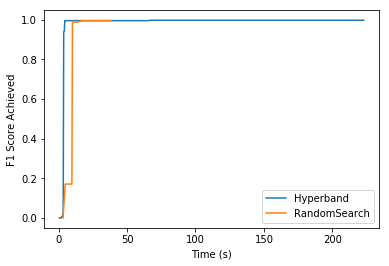

In [47]:
hb_stats_harder = hb_tuner_harder.run_stats
rs_stats_harder = rs_tuner_harder.run_stats
plot_score_vs_time(rs_stats_harder, hb_stats_harder)

Awesome! Generally it seems Hyperband is better in regimes with a large search space and a long search time (which is the typical scenario). 

This seems to make intuitive sense: 
- With a larger search space Hyperband's resource allocation becomes more useful in culling bad configurations.
- With a longer search time Hyperband is able to start with a larger pool of configurations, enabling a better balance of exploration / exploitation.

And that wraps up the hyperparameter tuning tutorial! We hope that MeTaL's hyperparameter tuners are useful for your applications and make hyperparameter tuning enjoyable. Happy tuning!